In [396]:
import os; os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10, QMNIST
from torchvision.models import (
    resnet18, ResNet18_Weights,
    efficientnet_b0, EfficientNet_B0_Weights, 
    efficientnet_b1, EfficientNet_B1_Weights, 
    efficientnet_b2, EfficientNet_B2_Weights, 
    efficientnet_b3, EfficientNet_B3_Weights, 
    efficientnet_b4, EfficientNet_B4_Weights, 
)
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')

In [3]:
from importlib import reload
import valuation, utils
reload(utils)
from valuation import get_relevance
# get_relevance(pca, buyer_data)

In [4]:
from valuation import compute_volumes, compute_X_tilde_and_counts, compute_robust_volumes, get_volume, get_relevance

In [477]:
svhn.labels

array([1, 9, 2, ..., 1, 6, 9])

In [567]:
root = Path('../data/')
download = True

mnist = MNIST(root=root, train=False, download=download)
emnist = EMNIST(root=root, split='digits', train=True, download=download)
qmnist = QMNIST(root=root, what='test50k', train=True, download=download)
svhn = SVHN(root=root, split='train', download=download)
fashion = FashionMNIST(root=root, train=False, download=download)
cifar = CIFAR10(root=root, train=False, download=download)

Using downloaded and verified file: ../data/train_32x32.mat
Files already downloaded and verified


In [457]:
mnist_data.shape, emnist_data.shape, qmnist_data.shape, svhn_data.shape, mnist_m_data.shape, dida_data.shape

(torch.Size([60000, 3, 32, 32]),
 torch.Size([240000, 3, 32, 32]),
 torch.Size([50000, 3, 32, 32]),
 torch.Size([73257, 3, 32, 32]),
 torch.Size([9001, 3, 32, 32]),
 torch.Size([10000, 3, 32, 32]))

In [573]:
from torchvision.transforms import Resize

resize = lambda x: Resize((32, 32))(torch.tensor(x))

mnist_data = resize(mnist.data.unsqueeze(1).repeat(1, 3, 1, 1))
mnist_targets = torch.tensor(mnist.targets)

emnist_data = resize(torch.fliplr(torch.rot90(emnist.data, k=1, dims=[1, 2])).unsqueeze(1).repeat(1, 3, 1, 1))
emnist_targets = torch.tensor(emnist.targets)

qmnist_data = resize(qmnist.data.unsqueeze(1).repeat(1, 3, 1, 1))
qmnist_targets = torch.tensor(qmnist.targets[:, 0])

svhn_data = resize(svhn.data)
svhn_targets = torch.tensor(svhn.labels)

fashion_data = resize(fashion.data.unsqueeze(1).repeat(1, 3, 1, 1))
fashion_targets = torch.tensor(fashion.targets)

cifar_data = resize(np.moveaxis(cifar.data, -1, 1))
cifar_targets = torch.tensor(cifar.targets)

/tmp/ipykernel_11048/1920713010.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resize = lambda x: Resize((32, 32))(torch.tensor(x))
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antia

In [262]:
from PIL import Image
from torchvision.transforms import Resize

dida = {int(p.stem): list(p.glob('*.jpg')) for p in ((root / 'DIDA-10k').glob('[!.]*'))}

dida_data_dict = {}
dida_targets_dict = {}
for target, image_paths in dida.items():
    images = []
    labels = []
    for p in image_paths:
        images.append(resize(np.moveaxis(np.array(Image.open(p)), -1, 0)))
        labels.append(target)
    dida_data_dict[target] = torch.stack(images)
    dida_targets_dict[target] = torch.tensor(labels)

In [263]:
dida_data = torch.tensor(np.concatenate(list(dida_data_dict.values())))
dida_targets = torch.cat(list(dida_targets_dict.values()))

In [264]:
dida_data.shape, dida_targets.shape

(torch.Size([10000, 3, 32, 32]), torch.Size([10000]))

In [265]:
import pandas as pd

In [460]:
df = pd.read_csv(root / 'mnist_m' / 'mnist_m_train_labels.txt', sep=' ', header=None, names=['image', 'label'])

,image,label
0,00000000.png,5
1,00000001.png,0
2,00000002.png,4
3,00000003.png,1
4,00000004.png,9
...,...,...
58996,00058996.png,8
58997,00058997.png,6
58998,00058998.png,6
58999,00058999.png,4


In [267]:
mnist_m_data = resize(np.moveaxis(np.stack([np.array(Image.open(root / 'mnist_m' / 'mnist_m_test' / img)) for img in df.image.values]), -1, 1))
mnist_m_targets = df.label.values

/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [268]:
mnist_m_data.shape, mnist_m_targets.shape

(torch.Size([9001, 3, 32, 32]), (9001,))

In [269]:
cifar_data.shape

torch.Size([10000, 3, 32, 32])

In [270]:
mnist_data.shape

torch.Size([10000, 3, 32, 32])

In [464]:
emnist.data.shape

torch.Size([240000, 28, 28])

In [571]:
torch.where(emnist_targets == 5)

(tensor([    20,     35,     55,  ..., 239986, 239989, 239993]),)

In [803]:
torch.where(svhn_targets == 5)[0][:10]

tensor([  5,  28,  36,  44,  46,  56,  58,  88, 113, 122])

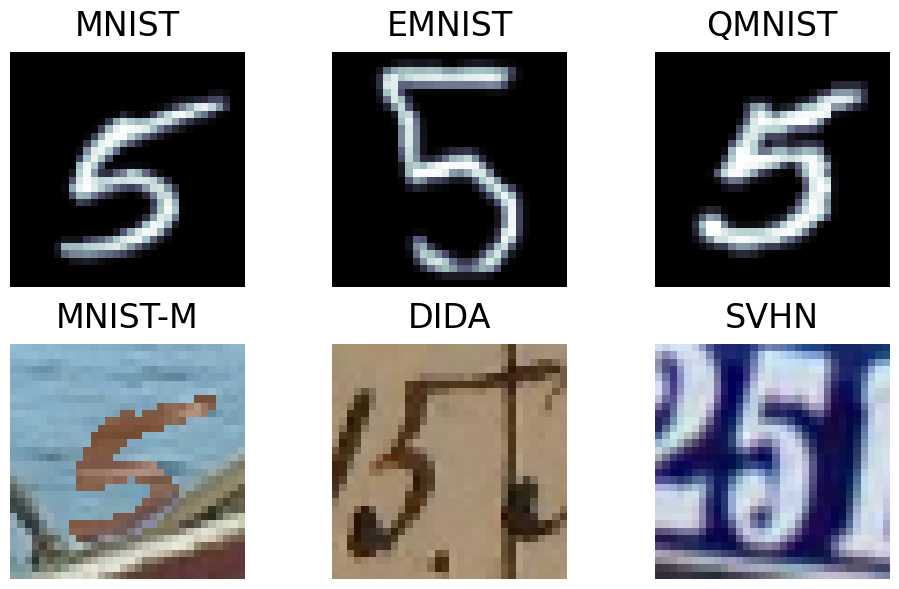

In [816]:
k = 0
fontsize=24
pad = 12

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

ax[0, 0].imshow(mnist_data[52][0], cmap=plt.cm.bone)
ax[0, 0].set_title(f'MNIST', fontsize=fontsize, pad=pad)
ax[0, 0].axis('off')
ax[0, 1].imshow(emnist_data[20][0], cmap=plt.cm.bone)
ax[0, 1].set_title(f'EMNIST', fontsize=fontsize, pad=pad)
ax[0, 1].axis('off')
ax[0, 2].imshow(qmnist_data[80][0], cmap=plt.cm.bone)
ax[0, 2].set_title(f'QMNIST', fontsize=fontsize, pad=pad)
ax[0, 2].axis('off')
# ax[0, 3].imshow(fashion_data[106][0], cmap=plt.cm.bone)
# ax[0, 3].set_title(f'FashionMNIST', fontsize=fontsize, pad=pad)
# ax[0, 3].axis('off')
ax[1, 0].imshow(torch.moveaxis(mnist_m_data[52], 0, -1))
ax[1, 0].set_title(f'MNIST-M', fontsize=fontsize, pad=pad)
ax[1, 0].axis('off')
ax[1, 1].imshow(torch.moveaxis(dida_data[4001], 0, -1))
ax[1, 1].set_title(f'DIDA', fontsize=fontsize, pad=pad)
ax[1, 1].axis('off')
ax[1, 2].imshow(torch.moveaxis(svhn_data[88], 0, -1))
ax[1, 2].set_title(f'SVHN', fontsize=fontsize, pad=pad)
ax[1, 2].axis('off')
# ax[1, 3].imshow(torch.moveaxis(cifar_data[16], 0, -1))
# ax[1, 3].set_title(f'CIFAR10', fontsize=fontsize, pad=pad)
# ax[1, 3].axis('off')

fig.tight_layout()
plt.savefig('figures/digits-images.png')

In [397]:
from torch.utils.data import TensorDataset, DataLoader

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1).cuda()
model.eval();

# upsample = lambda x: torch.nn.Upsample(scale_factor=2)(torch.tensor(x))
# resize = lambda x, size=64: Resize((size, size))(torch.tensor(x))
embed = lambda loader: torch.cat([model(x[0].cuda()).detach().cpu() for x in iter(loader)])
make_features = lambda x, batch_size=16: embed(DataLoader(TensorDataset(x / 255), batch_size=batch_size))

In [398]:
mnist_features = make_features(mnist_data)
emnist_features = make_features(emnist_data)
qmnist_features = make_features(qmnist_data)
# fashion_features = make_features(fashion_data)
mnist_m_features = make_features(mnist_m_data)
dida_features = make_features(dida_data)
svhn_features = make_features(svhn_data)
# cifar_features = make_features(cifar_data)

In [399]:
reload(valuation)
def get_value(pca, seller):
    rel = valuation.get_relevance(pca, seller)
    vol = valuation.get_volume(np.cov(pca.transform(seller).T))
    return rel, max(vol, 1e-5)

In [537]:
num_samples = 100

buyer_data = mnist_features[:num_samples]
# buyer_data = emnist_features[:num_samples]
# buyer_data = qmnist_features[:num_samples]
# buyer_data = mnist_m_features[:num_samples]
# buyer_data = svhn_features[:num_samples]
buyer_data = dida_features[:num_samples]

n_components=5
# n_components=20
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
pca.fit(buyer_data)
pca.explained_variance_

seller1_data = mnist_features[:num_samples]
seller2_data = emnist_features[:num_samples]
seller3_data = qmnist_features[:num_samples]
# seller4_data = fashion_features[:num_samples]
seller5_data = mnist_m_features[:num_samples]
seller6_data = dida_features[:num_samples]
seller7_data = svhn_features[:num_samples]
# seller8_data = cifar_features[:num_samples]


# buyer_rel, buyer_div = get_value(pca, buyer_data)
seller1_rel, seller1_div = get_value(pca, seller1_data)
seller2_rel, seller2_div = get_value(pca, seller2_data)
seller3_rel, seller3_div = get_value(pca, seller3_data)
# seller4_rel, seller4_div = get_value(pca, seller4_data)
seller5_rel, seller5_div = get_value(pca, seller5_data)
seller6_rel, seller6_div = get_value(pca, seller6_data)
seller7_rel, seller7_div = get_value(pca, seller7_data)
# seller8_rel, seller8_div = get_value(pca, seller8_data)

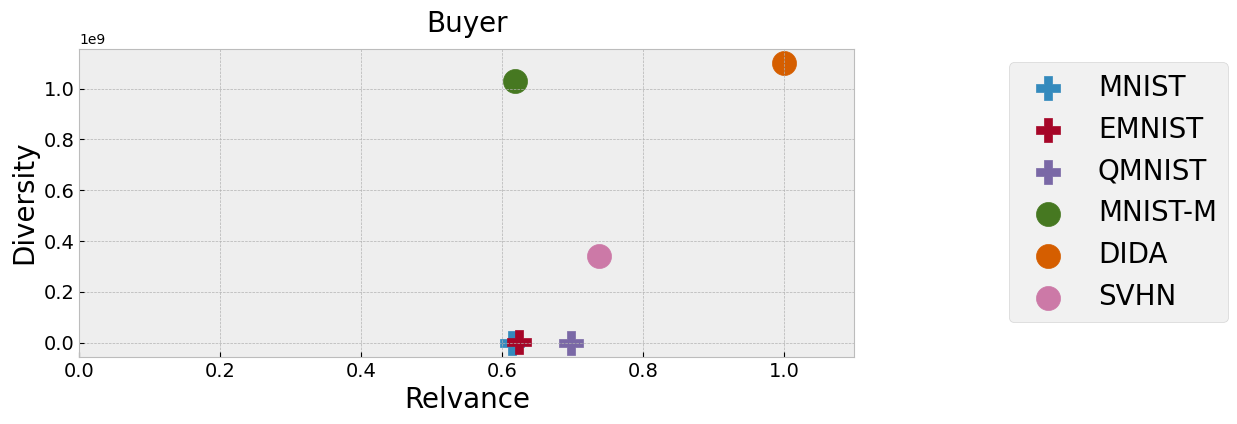

In [615]:
plt.figure(figsize=(10, 4))
plt.scatter(seller1_rel, seller1_div, s=300, marker='P', label='MNIST')
plt.scatter(seller2_rel, seller2_div, s=300, marker='P', label='EMNIST')
plt.scatter(seller3_rel, seller3_div, s=300, marker='P', label='QMNIST')
# plt.scatter(seller4_rel, seller4_div, s=100, marker='D', label='FashionMNIST')
plt.scatter(seller5_rel, seller5_div, s=300, marker='o', label='MNIST-M')
plt.scatter(seller6_rel, seller6_div, s=300, marker='o', label='DIDA')
plt.scatter(seller7_rel, seller7_div, s=300, marker='o', label='SVHN')
# plt.scatter(seller8_rel, seller8_div, label='CIFAR')
plt.xlabel('Relvance', fontsize=20)
plt.ylabel('Diversity', fontsize=20)
plt.xlim(0, 1.1)
plt.title('Buyer', fontsize=20, pad=12)
plt.tick_params(labelsize=14)
plt.legend(fontsize=20, bbox_to_anchor=(1.5, 1))

In [443]:
import models
reload(models)

batch_size = 32
epochs = 10

make_image_loader = lambda x, y, batch_size=batch_size: DataLoader(TensorDataset(torch.tensor(x) / 255, torch.tensor(y)), drop_last=False, batch_size=batch_size)

buyer_data = svhn_data[:num_samples]
buyer_targets = svhn_targets[:num_samples]
buyer_loader = make_image_loader(buyer_data, buyer_targets)

seller_data = mnist_m_data[:num_samples]
seller_targets = mnist_m_targets[:num_samples]
seller_loader = make_image_loader(seller_data, seller_targets)

/tmp/ipykernel_11048/361531366.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  make_image_loader = lambda x, y, batch_size=batch_size: DataLoader(TensorDataset(torch.tensor(x) / 255, torch.tensor(y)), drop_last=False, batch_size=batch_size)


In [444]:
CNN_c = models.CNN().cuda()
CNN_r = models.CNN(regressor=True).cuda()

cnn_c_opt = torch.optim.SGD(CNN_c.parameters(), lr=1e-2)
cnn_r_opt = torch.optim.SGD(CNN_r.parameters(), lr=1e-2)
cnn_c_train_loss = models.fit(CNN_c, seller_loader, cnn_c_opt, epochs=epochs)
cnn_r_train_loss = models.fit(CNN_r, seller_loader, cnn_r_opt, classification=False, epochs=epochs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]


In [445]:
cnn_c_buyer_pred = torch.cat([CNN_c(x.cuda()).detach().cpu() for x, _ in buyer_loader])
cnn_r_buyer_pred = torch.cat([CNN_r(x.cuda()).detach().cpu() for x, _ in buyer_loader])

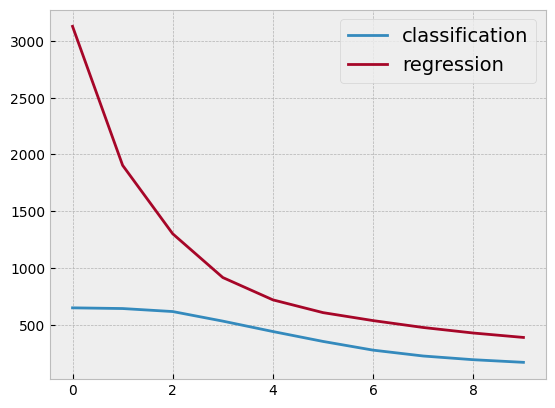

In [446]:
plt.plot(*zip(*cnn_c_train_loss.items()), label='classification')
plt.plot(*zip(*cnn_r_train_loss.items()), label='regression')
plt.legend(fontsize=14)
# plt.yscale('log')

In [447]:
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error
print(classification_report(buyer_targets, cnn_c_buyer_pred.argmax(1).detach().cpu().numpy()))
print(accuracy_score(buyer_targets, cnn_c_buyer_pred.argmax(1).detach().cpu().numpy()))
print(mean_absolute_error(buyer_targets, cnn_r_buyer_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.49      0.27      0.35       684
           1       0.47      0.84      0.61      1968
           2       0.85      0.13      0.22      1590
           3       0.38      0.50      0.43      1104
           4       0.45      0.31      0.37       964
           5       0.68      0.25      0.36       909
           6       0.29      0.10      0.14       773
           7       0.43      0.32      0.36       767
           8       0.17      0.25      0.21       621
           9       0.15      0.41      0.22       620

    accuracy                           0.39     10000
   macro avg       0.44      0.34      0.33     10000
weighted avg       0.48      0.39      0.36     10000

0.3867
2.2191860177874565


In [540]:
import json
perf = json.load(open('results/performances.json'))
val = json.load(open('results/valuations.json'))

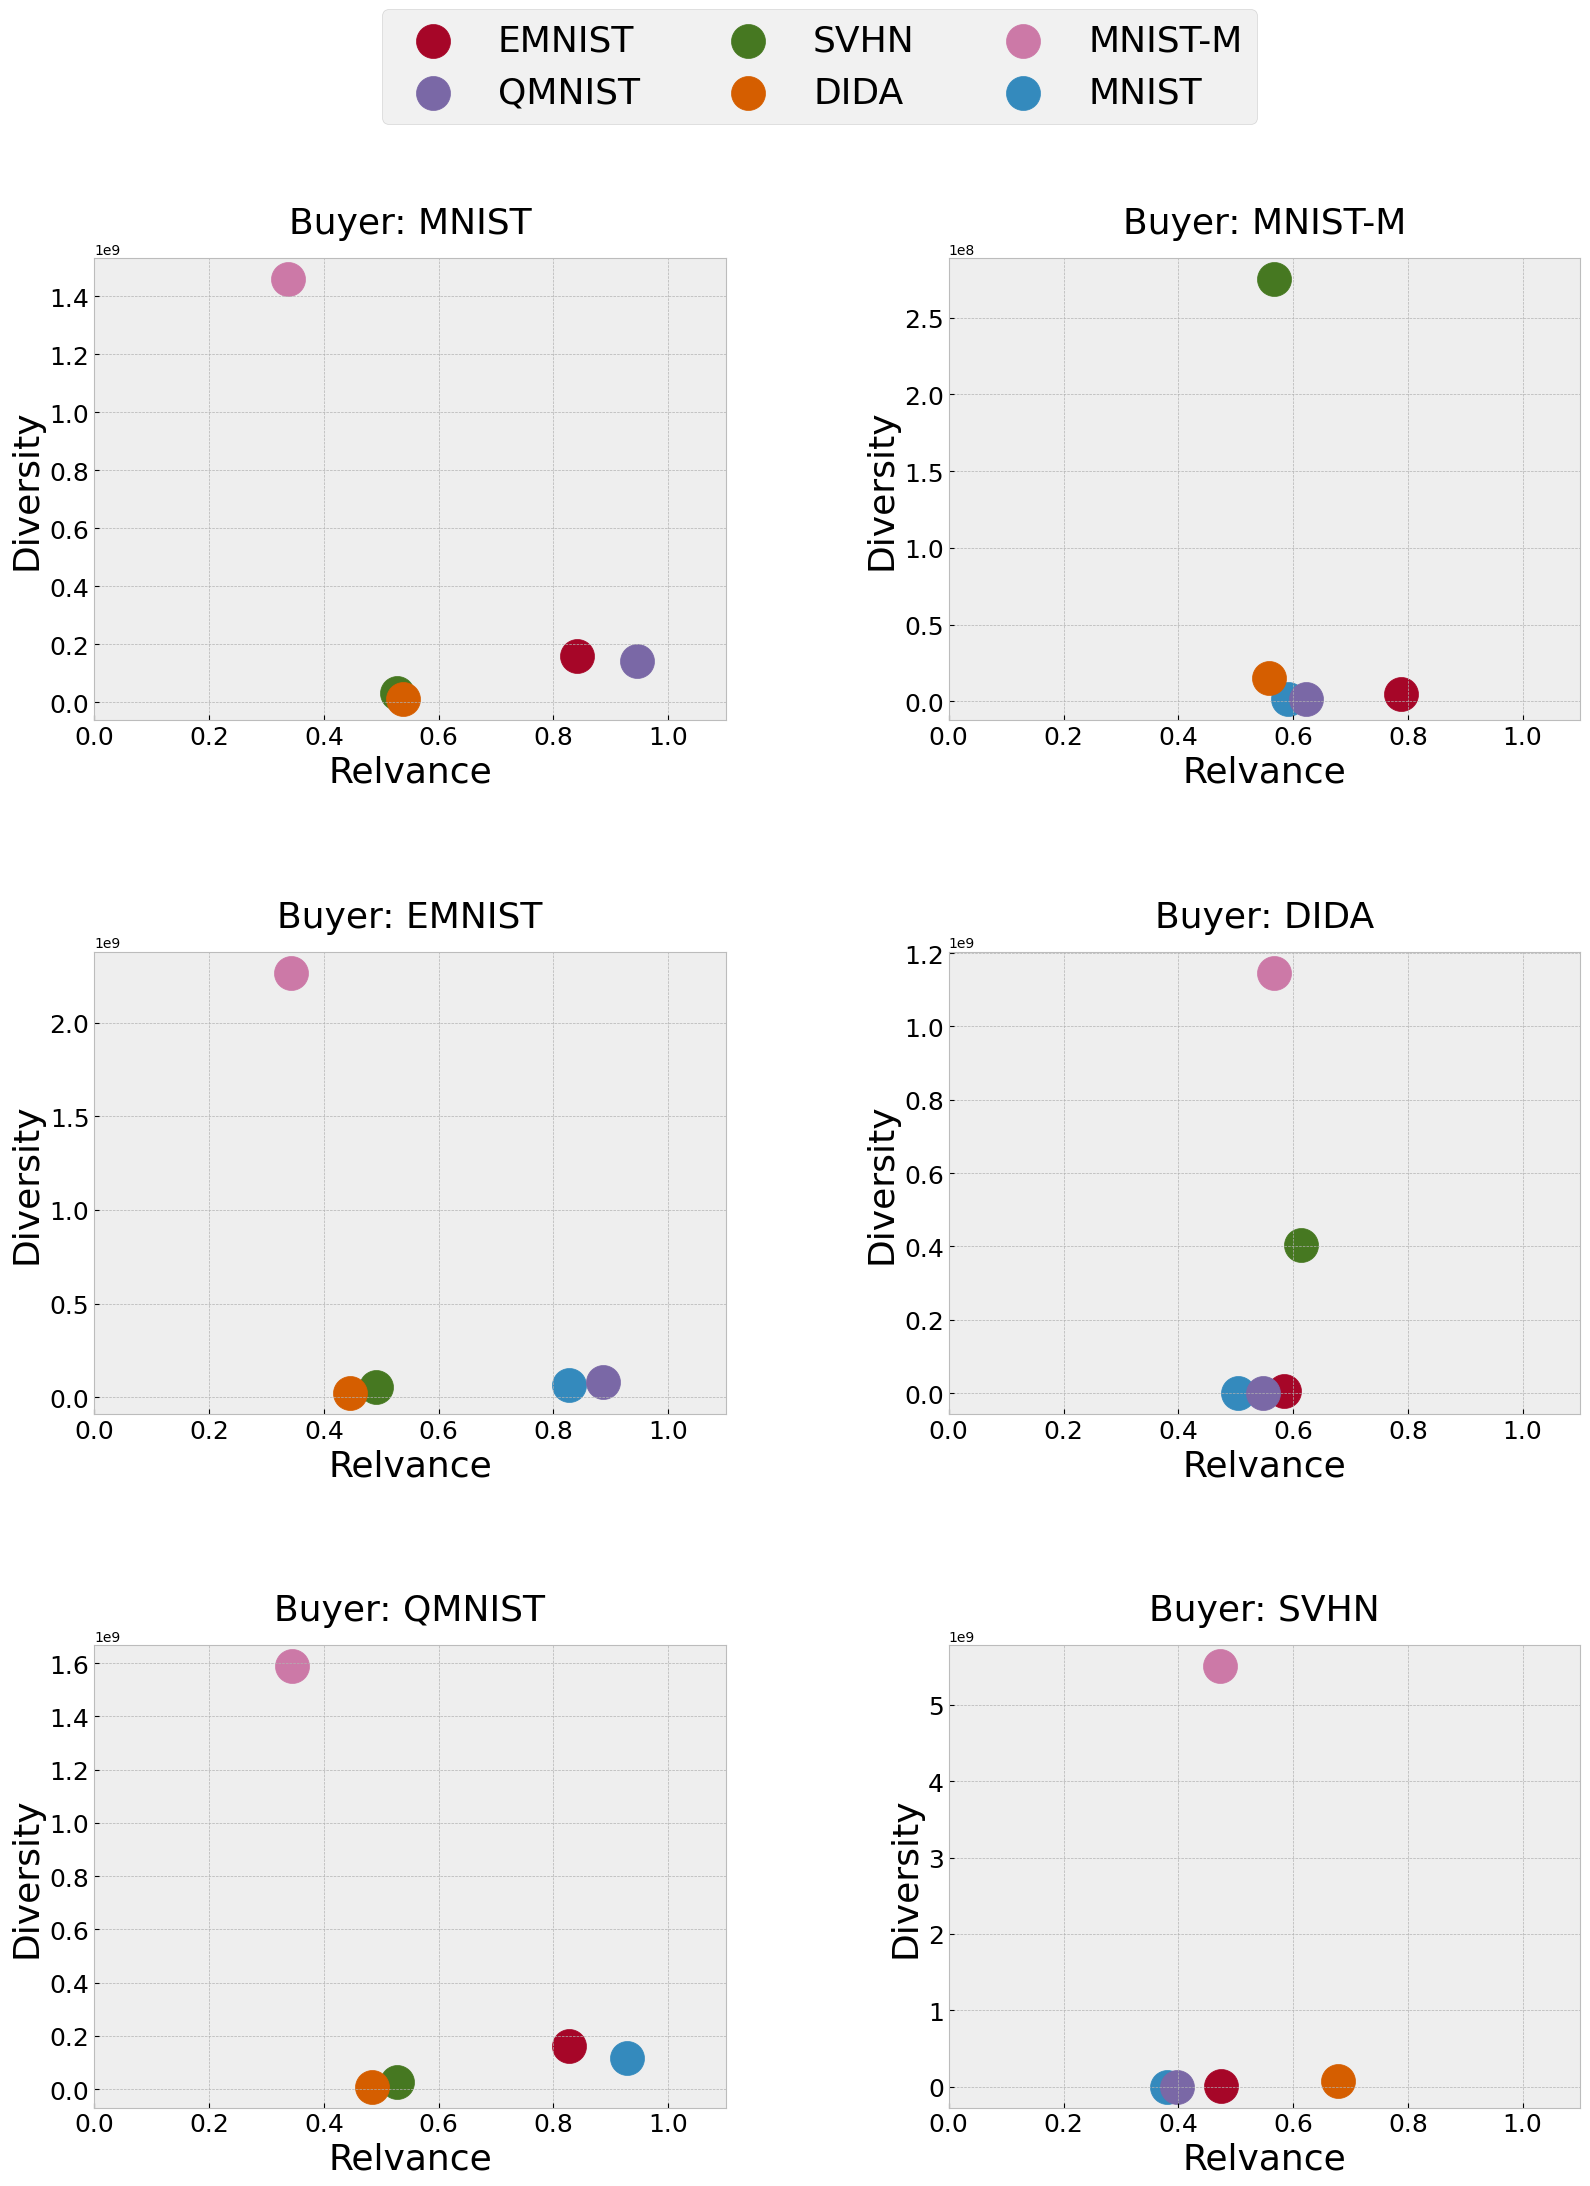

In [765]:
labelsize = 18
fontsize = 26
pad = 18
s = 600
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 20))


color_map = {
    'MNIST': 'C0', 
    'EMNIST': 'C1', 
    'QMNIST': 'C2', 
    'SVHN': 'C3', 
    'DIDA': 'C4', 
    'MNIST-M': 'C5',
}

    
for seller, vals in val['MNIST-M'].items():
    if seller == 'MNIST-M': continue
    rel = vals['relevance']
    div = vals['diversity']
    ax[0, 1].scatter(rel, div, s=s, marker='o', c=color_map[seller])
    ax[0, 1].set_xlabel('Relvance', fontsize=fontsize)
    ax[0, 1].set_ylabel('Diversity', fontsize=fontsize)
    ax[0, 1].set_xlim(0, 1.1)
    ax[0, 1].set_title(f'Buyer: MNIST-M', fontsize=fontsize, pad=pad)
    ax[0, 1].tick_params(labelsize=labelsize)

for seller, vals in val['MNIST'].items():
    if seller == 'MNIST': continue
    rel = vals['relevance']
    div = vals['diversity']
    ax[0, 0].scatter(rel, div, s=s, marker='o', c=color_map[seller])
    ax[0, 0].set_xlabel('Relvance', fontsize=fontsize)
    ax[0, 0].set_ylabel('Diversity', fontsize=fontsize)
    ax[0, 0].set_xlim(0, 1.1)
    ax[0, 0].set_title(f'Buyer: MNIST', fontsize=fontsize, pad=pad)
    ax[0, 0].tick_params(labelsize=labelsize)
    
for seller, vals in val['EMNIST'].items():
    if seller == 'EMNIST': continue
    rel = vals['relevance']
    div = vals['diversity']
    ax[1, 0].scatter(rel, div, s=s, marker='o', c=color_map[seller])
    ax[1, 0].set_xlabel('Relvance', fontsize=fontsize)
    ax[1, 0].set_ylabel('Diversity', fontsize=fontsize)
    ax[1, 0].set_xlim(0, 1.1)
    ax[1, 0].set_title(f'Buyer: EMNIST', fontsize=fontsize, pad=pad)
    ax[1, 0].tick_params(labelsize=labelsize)
    
    
for seller, vals in val['QMNIST'].items():
    if seller == 'QMNIST': continue
    rel = vals['relevance']
    div = vals['diversity']
    ax[2, 0].scatter(rel, div, s=s, marker='o', c=color_map[seller])
    ax[2, 0].set_xlabel('Relvance', fontsize=fontsize)
    ax[2, 0].set_ylabel('Diversity', fontsize=fontsize)
    ax[2, 0].set_xlim(0, 1.1)
    ax[2, 0].set_title(f'Buyer: QMNIST', fontsize=fontsize, pad=pad)
    ax[2, 0].tick_params(labelsize=labelsize)
    
    
for seller, vals in val['DIDA'].items():
    if seller == 'DIDA': continue
    rel = vals['relevance']
    div = vals['diversity']
    ax[1, 1].scatter(rel, div, s=s, marker='o', c=color_map[seller])
    ax[1, 1].set_xlabel('Relvance', fontsize=fontsize)
    ax[1, 1].set_ylabel('Diversity', fontsize=fontsize)
    ax[1, 1].set_xlim(0, 1.1)
    ax[1, 1].set_title(f'Buyer: DIDA', fontsize=fontsize, pad=pad)
    ax[1, 1].tick_params(labelsize=labelsize)
    
    
for seller, vals in val['SVHN'].items():
    if seller == 'SVHN': continue
    rel = vals['relevance']
    div = vals['diversity']
    ax[2, 1].scatter(rel, div, s=s, marker='o', c=color_map[seller])
    ax[2, 1].set_xlabel('Relvance', fontsize=fontsize)
    ax[2, 1].set_ylabel('Diversity', fontsize=fontsize)
    ax[2, 1].set_xlim(0, 1.1)
    ax[2, 1].set_title(f'Buyer: SVHN', fontsize=fontsize, pad=pad)
    ax[2, 1].tick_params(labelsize=labelsize)
    
fig.legend(['EMNIST', 'QMNIST', 'SVHN', 'DIDA', 'MNIST-M', 'MNIST'], fontsize=fontsize, ncols=3, bbox_to_anchor=(0.80, 1.10))
fig.tight_layout(w_pad=10, h_pad=8)
plt.savefig('figures/digits-valuation.png', bbox_inches='tight')

In [636]:
div_acc = {}
rel_acc = {}
div_mae = {}
rel_mae = {}

for buyer in ['MNIST', 'EMNIST', 'QMNIST', 'SVHN', 'DIDA', 'MNIST-M']:
    for seller in ['MNIST', 'EMNIST', 'QMNIST', 'SVHN', 'DIDA', 'MNIST-M']:
        if buyer == seller: continue
        div = val[buyer][seller]['diversity']
        rel = val[buyer][seller]['relevance']
        acc = perf[buyer][seller]['metrics']['accuracy']
        mae = perf[buyer][seller]['metrics']['MAE']
        div_acc[div] = acc
        rel_acc[rel] = acc
        div_mae[div] = mae
        rel_mae[rel] = mae

In [675]:
def best_fit(d: dict, points: int = 100):
    x, y = zip(*d.items())
    m, b = np.polyfit(x, y, 1)
    rang = np.linspace(min(x), max(x), points)
    return rang, rang * m + b

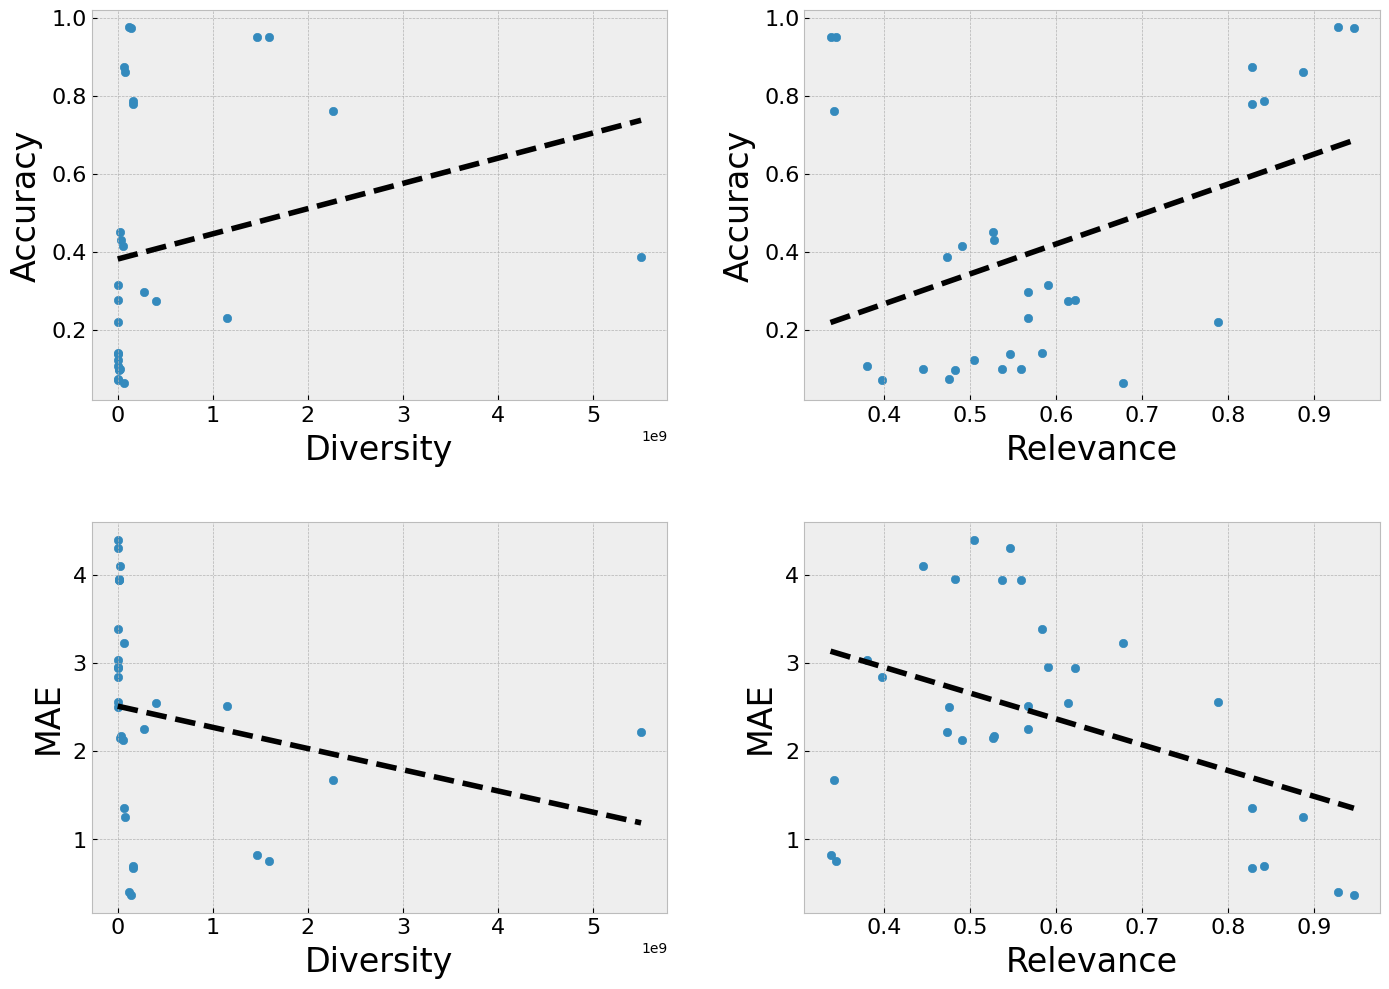

In [704]:
fs = 24
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

ax[0, 0].plot(*best_fit(div_acc), '--', color='black', lw=4)
ax[0, 0].scatter(*zip(*div_acc.items()))
# ax[0, 0].set_xscale('log')
ax[0, 0].set_xlabel('Diversity', fontsize=fs, labelpad=6)
ax[0, 0].set_ylabel('Accuracy', fontsize=fs, labelpad=6)
ax[0, 0].tick_params(labelsize=16)

ax[0, 1].plot(*best_fit(rel_acc), '--', color='black', lw=4)
ax[0, 1].scatter(*zip(*rel_acc.items()))
# ax[0, 1].set_xscale('log')
ax[0, 1].set_xlabel('Relevance', fontsize=fs, labelpad=6)
ax[0, 1].set_ylabel('Accuracy', fontsize=fs, labelpad=6)
ax[0, 1].tick_params(labelsize=16)

ax[1, 0].plot(*best_fit(div_mae), '--', color='black', lw=4)
ax[1, 0].scatter(*zip(*div_mae.items()))
# ax[1, 0].set_xscale('log')
ax[1, 0].set_xlabel('Diversity', fontsize=fs, labelpad=6)
ax[1, 0].set_ylabel('MAE', fontsize=fs, labelpad=6)
ax[1, 0].tick_params(labelsize=16)

ax[1, 1].plot(*best_fit(rel_mae), '--', color='black', lw=4)
ax[1, 1].scatter(*zip(*rel_mae.items()))
# ax[1, 1].set_xscale('log')
ax[1, 1].set_xlabel('Relevance', fontsize=fs, labelpad=6)
ax[1, 1].set_ylabel('MAE', fontsize=fs, labelpad=6)
ax[1, 1].tick_params(labelsize=16)

fig.tight_layout(w_pad=4, h_pad=4)
plt.savefig('figures/cifar-correlations.png', bbox_inches='tight')

In [618]:
buyer = 'DIDA'
for seller, values in val[buyer].items():
    print(seller.center(20, '='))
    print(f"    {values['relevance']:.2f} ", f" {values['diversity']:.1e}")
    

=======MNIST========
    0.50   6.8e+05
=======EMNIST=======
    0.58   4.8e+06
=======QMNIST=======
    0.55   8.2e+05
========SVHN========
    0.61   4.0e+08
========DIDA========
    1.00   7.5e+08
======MNIST-M=======
    0.57   1.1e+09


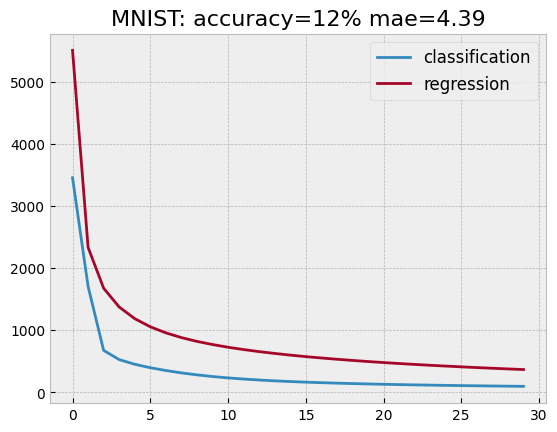

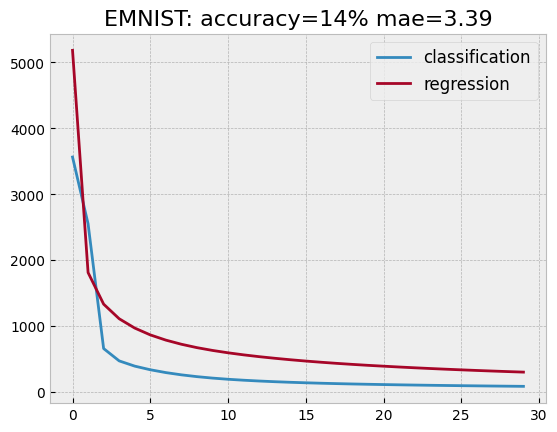

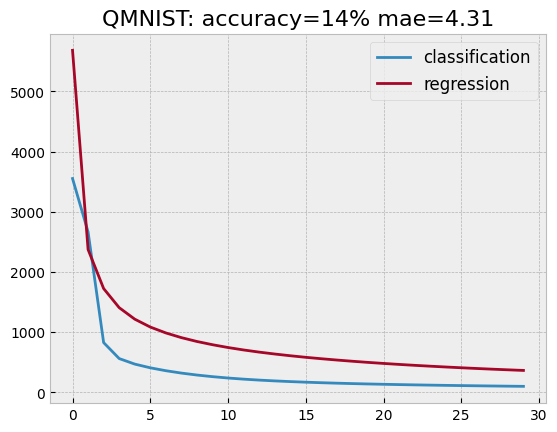

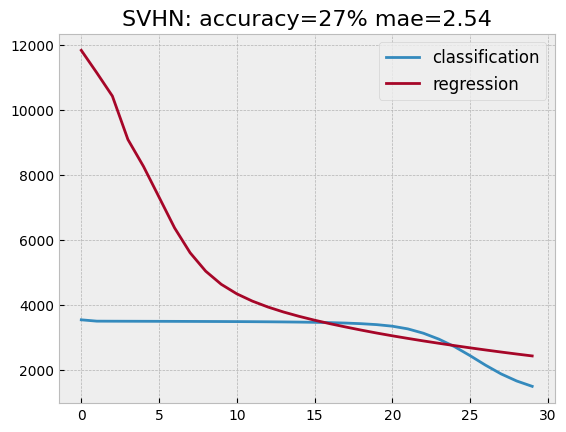

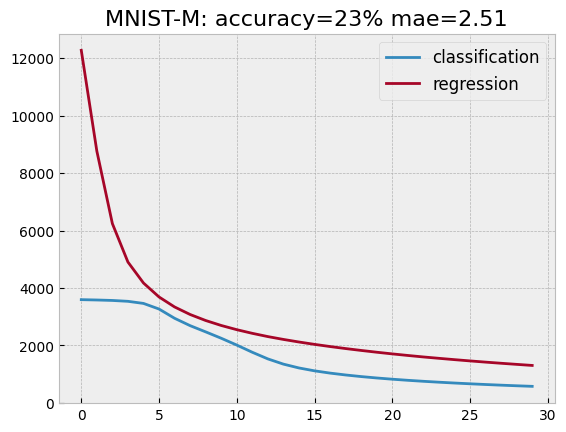

In [620]:
for seller, results in perf[buyer].items():
    metrics = results['metrics']
    losses = results['losses']
    accuracy = metrics['accuracy']
    mae = metrics['MAE']
    plt.title(f"{seller}: {accuracy=:.0%} {mae=:.2f}", fontsize=16)
    plt.plot(losses['classification'].values(), label='classification')
    plt.plot(losses['regression'].values(), label='regression')
    plt.legend(fontsize=12)
    plt.show()
    

In [325]:
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        # emnist_features[:num_samples], torch.tensor(emnist_targets[:num_samples]), 
        emnist_data[:num_samples] / 255, torch.tensor(emnist_targets[:num_samples]), 
    ), 
    batch_size=batch_size)

x, y = next(iter(train_loader))

/tmp/ipykernel_11048/1845504076.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_data[:num_samples] / 255, torch.tensor(emnist_targets[:num_samples]),


In [327]:
SC = models.SoftmaxClassifier().cuda()
LR = models.LinearRegression().cuda()

sc_opt = torch.optim.SGD(SC.parameters(), lr=1e-1)
lr_opt = torch.optim.SGD(LR.parameters(), lr=1e-4)
sc_train_loss = models.fit(SC, seller_loader, sc_opt, epochs=epochs)
lr_train_loss = models.fit(LR, seller_loader, lr_opt, classification=False, epochs=epochs)

sc_buyer_pred = SC(buyer_data.cuda())
lr_buyer_pred = LR(buyer_data.cuda())

  0%|                                                                                                        | 0/25 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3072x32 and 1000x10)

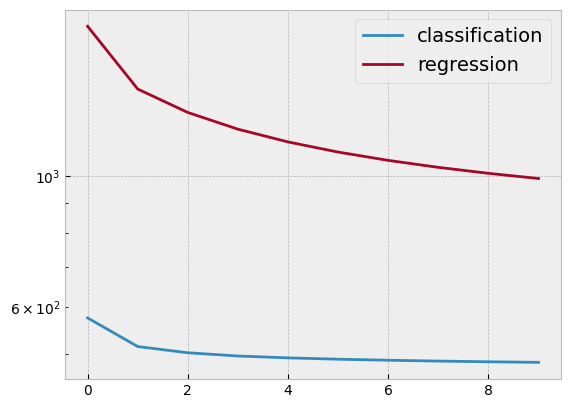

In [109]:
plt.plot(*zip(*sc_train_loss.items()), label='classification')
plt.plot(*zip(*lr_train_loss.items()), label='regression')
plt.legend(fontsize=14)
plt.yscale('log')

In [110]:
from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error
print(classification_report(buyer_labels, sc_buyer_pred.argmax(1).detach().cpu().numpy()))
print(accuracy_score(buyer_labels, sc_buyer_pred.argmax(1).detach().cpu().numpy()))
print(mean_absolute_error(buyer_labels, lr_buyer_pred.detach().cpu().numpy()))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       980
           1       0.96      0.99      0.97      1135
           2       0.94      0.61      0.74      1032
           3       0.84      0.79      0.81      1010
           4       0.81      0.90      0.85       982
           5       0.82      0.68      0.74       892
           6       0.66      0.96      0.78       958
           7       0.90      0.77      0.83      1028
           8       0.88      0.91      0.89       974
           9       0.78      0.91      0.84      1009

    accuracy                           0.85     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.86      0.85      0.84     10000

0.846
1.6201456806142815


In [5]:
mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)

In [6]:
# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1).cuda()
# model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1).cuda()

model.eval();

upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)

embed = lambda loader: torch.cat([model(x.cuda()).detach().cpu() for x in iter(loader)])

batch_size = 16
mnist_buyer_loader = torch.utils.data.DataLoader(upsample(mnist_buyer.data.unsqueeze(1).repeat(1, 3, 1, 1) / 255), batch_size=batch_size)
mnist_buyer_features = embed(mnist_buyer_loader)

mnist_seller_loader = torch.utils.data.DataLoader(upsample(mnist_seller.data.unsqueeze(1).repeat(1, 3, 1, 1) / 255), batch_size=batch_size)
mnist_seller_features = embed(mnist_seller_loader)

In [8]:
buyer_mask = (
    (mnist_buyer.targets == 0)
    | (mnist_buyer.targets == 1)
    | (mnist_buyer.targets == 2)
    | (mnist_buyer.targets == 3) 
    | (mnist_buyer.targets == 4)
)
buyer_data = mnist_buyer_features[buyer_mask]
buyer_data -= buyer_data.mean(0)
buyer_cov = np.cov(buyer_data.T)
buyer_labels = mnist_buyer.targets[buyer_mask]

In [9]:
n = 10000

seller_1_mask = (
    (mnist_seller.targets == 0) 
    # | (mnist_seller.targets == 1) 
    # | (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_1_data = mnist_seller_features[seller_1_mask][:n]
seller_1_labels = mnist_seller.targets[seller_1_mask][:n]

seller_2_mask = (
    (mnist_seller.targets == 0) 
    | (mnist_seller.targets == 1) 
    # | (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_2_data = mnist_seller_features[seller_2_mask][:n]
seller_2_labels = mnist_seller.targets[seller_2_mask][:n]

seller_3_mask = (
    (mnist_seller.targets == 0) 
    | (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_3_data = mnist_seller_features[seller_3_mask][:n]
seller_3_labels = mnist_seller.targets[seller_3_mask][:n]

seller_4_mask = (
    (mnist_seller.targets == 0) 
    | (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_4_data = mnist_seller_features[seller_4_mask][:n]
seller_4_labels = mnist_seller.targets[seller_4_mask][:n]

seller_5_mask = (
    (mnist_seller.targets == 0) 
    | (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_5_data = mnist_seller_features[seller_5_mask][:n]
seller_5_labels = mnist_seller.targets[seller_5_mask][:n]

seller_6_mask = (
    # (mnist_seller.targets == 0) 
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_6_data = mnist_seller_features[seller_6_mask][:n]
seller_6_labels = mnist_seller.targets[seller_6_mask][:n]

seller_7_mask = (
    # (mnist_seller.targets == 0) 
    # | (mnist_seller.targets == 1) 
    (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_7_data = mnist_seller_features[seller_7_mask][:n]
seller_7_labels = mnist_seller.targets[seller_7_mask][:n]

seller_8_mask = (
    # (mnist_seller.targets == 0) 
    # | (mnist_seller.targets == 1) 
    # (mnist_seller.targets == 2)
    (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_8_data = mnist_seller_features[seller_8_mask][:n]
seller_8_labels = mnist_seller.targets[seller_8_mask][:n]

seller_9_mask = (
    # (mnist_seller.targets == 0) 
    # | (mnist_seller.targets == 1) 
    # (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
)
seller_9_data = mnist_seller_features[seller_9_mask][:n]
seller_9_labels = mnist_seller.targets[seller_9_mask][:n]

seller_10_mask = (
    # (mnist_seller.targets == 0) 
    # | (mnist_seller.targets == 1) 
    # (mnist_seller.targets == 2)
    # | (mnist_seller.targets == 3) 
    # (mnist_seller.targets == 4)
    (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
)
seller_10_data = mnist_seller_features[seller_10_mask][:n]
seller_10_labels = mnist_seller.targets[seller_10_mask][:n]


seller_1_data -= seller_1_data.mean(0)
seller_2_data -= seller_2_data.mean(0)
seller_3_data -= seller_3_data.mean(0)
seller_4_data -= seller_4_data.mean(0)
seller_5_data -= seller_5_data.mean(0)
seller_6_data -= seller_6_data.mean(0)
seller_7_data -= seller_7_data.mean(0)
seller_8_data -= seller_8_data.mean(0)
seller_9_data -= seller_9_data.mean(0)
seller_10_data -= seller_10_data.mean(0)

seller_1_cov = np.cov(seller_1_data.T)
seller_2_cov = np.cov(seller_2_data.T)
seller_3_cov = np.cov(seller_3_data.T)
seller_4_cov = np.cov(seller_4_data.T)
seller_5_cov = np.cov(seller_5_data.T)
seller_6_cov = np.cov(seller_6_data.T)
seller_7_cov = np.cov(seller_7_data.T)
seller_8_cov = np.cov(seller_8_data.T)
seller_9_cov = np.cov(seller_9_data.T)
seller_10_cov = np.cov(seller_10_data.T)

In [10]:
# pca = PCA(n_components=5, svd_solver='randomized', whiten=True)
pca = PCA(n_components=10, svd_solver='randomized', whiten=False)
pca.fit(buyer_data)
pca.explained_variance_

array([95.88657696, 24.56458789, 14.70248905, 11.10956844,  7.80068322,
        5.05688866,  3.63435003,  3.23210759,  2.86255315,  2.51023357])

In [11]:
reload(utils)
def get_value(pca, seller):
    rel = utils.get_relevance(pca, seller)
    vol = utils.get_volume(np.cov(pca.transform(seller).T))
    return rel, max(vol, 1e-5)

In [12]:
import matplotlib
k = 5
viridis = np.array(matplotlib.colormaps['viridis'].colors)[np.linspace(0, 255, k).astype(int)]
plasma = np.array(matplotlib.colormaps['plasma'].colors)[np.linspace(0, 255, 5).astype(int)]

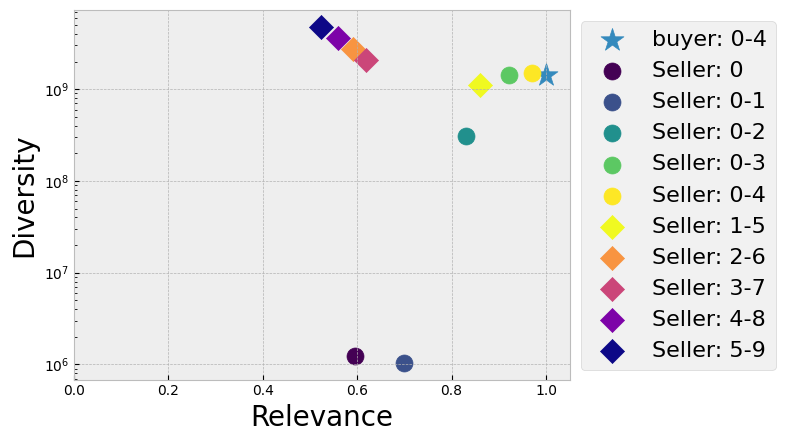

In [13]:
s = 150

plt.scatter(*get_value(pca, buyer_data), label='buyer: 0-4', s=2*s, marker='*')
plt.scatter(*get_value(pca, seller_1_data), color=viridis[0], s=s, marker='o', label='Seller: 0')
plt.scatter(*get_value(pca, seller_2_data), color=viridis[1], s=s, marker='o', label='Seller: 0-1')
plt.scatter(*get_value(pca, seller_3_data), color=viridis[2], s=s, marker='o', label='Seller: 0-2')
plt.scatter(*get_value(pca, seller_4_data), color=viridis[3], s=s, marker='o', label='Seller: 0-3')
plt.scatter(*get_value(pca, seller_5_data), color=viridis[4], s=s, marker='o', label='Seller: 0-4')
plt.scatter(*get_value(pca, seller_6_data), color=plasma[4], s=s, marker='D', label='Seller: 1-5')
plt.scatter(*get_value(pca, seller_7_data), color=plasma[3], s=s, marker='D', label='Seller: 2-6')
plt.scatter(*get_value(pca, seller_8_data), color=plasma[2], s=s, marker='D', label='Seller: 3-7')
plt.scatter(*get_value(pca, seller_9_data), color=plasma[1], s=s, marker='D', label='Seller: 4-8')
plt.scatter(*get_value(pca, seller_10_data),color=plasma[0], s=s, marker='D', label='Seller: 5-9')
plt.yscale('log')
plt.xlim(0.0, 1.05)
plt.xlabel('Relevance', fontsize=20)
plt.ylabel('Diversity', fontsize=20)
plt.legend(fontsize=16, title_fontsize=18, bbox_to_anchor=(1.00, 1.00), ncol=1)
# plt.savefig(f'mnist-diversity.png', bbox_inches='tight')

In [14]:
import models
reload(models)

batch_size = 32
seller_4_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        seller_4_data, seller_4_labels, 
    ), 
    batch_size=batch_size)

x, y = next(iter(seller_4_loader))

reload(models)
SC = models.SoftmaxClassifier().cuda()
LR = models.LinearRegression().cuda()
sc_opt = torch.optim.SGD(SC.parameters(), lr=1e-1)
lr_opt = torch.optim.SGD(LR.parameters(), lr=1e-1)
# sc_train_loss = models.fit(SC, seller_4_loader, opt, epochs=5)
lr_train_loss = models.fit(LR, seller_4_loader, opt, classification=False, epochs=5)

# buyer_pred = SC(buyer_data.cuda())
buyer_pred = LR(buyer_data.cuda())

from sklearn.metrics import classification_report, accuracy_score, mean_absolute_error
# print(classification_report(buyer_labels, buyer_pred.argmax(1).detach().cpu().numpy()))
# print(accuracy_score(buyer_labels, buyer_pred.argmax(1).detach().cpu().numpy()))
print(mean_absolute_error(buyer_labels, buyer_pred.detach().cpu().numpy()))

In [ ]:
# n_components = 50
# n_components = 20
# n_components = 15
# n_components = 10
n_components = 2
whiten       = True
# use_features = False 
use_features = True

X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)
buyer_cov = np.cov(X_b.T)

buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)
buyer_eig_val = buyer_eig_val.real
buyer_eig_vec = buyer_eig_vec.real
print(buyer_eig_val[:n_components])
print(X_b @ buyer_eig_vec[:, :n_components])

In [102]:
(np.cov(
    (
        mnist_buyer_features[
            # (mnist_buyer.targets == 1)
            ( mnist_buyer.targets == 2)
            | (mnist_buyer.targets == 3) 
            | (mnist_buyer.targets == 4)
            | (mnist_buyer.targets == 5) 
            # | (mnist_buyer.targets == 6)
        ][:100]
        - mnist_buyer_features[
            # (mnist_buyer.targets == 1)
            ( mnist_buyer.targets == 2)
            | (mnist_buyer.targets == 3) 
            | (mnist_buyer.targets == 4)
            | (mnist_buyer.targets == 5) 
            # | (mnist_buyer.targets == 6)
        ][:100].mean(0)
    ).T
) @ eig_vec[:, :5]).real

array([[ 0.42073469, -0.604131  , -0.46812137, -0.09070648, -0.08075475],
       [ 1.25021687, -0.17979735, -0.43780573,  0.06698081,  0.19572634],
       [-2.25650782, -0.56598033,  0.29584861, -0.19486821,  0.26914364],
       ...,
       [ 1.33098763, -0.75450409, -0.43891952, -0.12299085, -0.188784  ],
       [ 0.27218723,  0.2933185 ,  0.28706455, -0.16328166, -0.19196848],
       [-1.16878095, -3.81004668,  0.0538549 , -0.14150643,  0.06117587]])

In [80]:
eig_val, eig_vec = np.linalg.eig(
    np.cov(
        (
            mnist_buyer_features[
                # (mnist_buyer.targets == 1)
                ( mnist_buyer.targets == 2)
                | (mnist_buyer.targets == 3) 
                | (mnist_buyer.targets == 4)
                | (mnist_buyer.targets == 5) 
                # | (mnist_buyer.targets == 6)
            ][:100]
            - mnist_buyer_features[
                # (mnist_buyer.targets == 1)
                ( mnist_buyer.targets == 2)
                | (mnist_buyer.targets == 3) 
                | (mnist_buyer.targets == 4)
                | (mnist_buyer.targets == 5) 
                # | (mnist_buyer.targets == 6)
            ][:100].mean(0)
        ).T
    )
)

In [68]:
# plt.imshow(eig_vec @ eig_vec.T)

In [84]:
pca.explained_variance_

array([69.35879993, 35.9183598 , 14.00217319, 10.55732806,  6.26711425])

In [62]:
mnist_buyer_features.shape

torch.Size([10000, 1000])

In [63]:

    np.cov((mnist_buyer_features[
        # (mnist_buyer.targets == 1)
        ( mnist_buyer.targets == 2)
        | (mnist_buyer.targets == 3) 
        | (mnist_buyer.targets == 4)
        | (mnist_buyer.targets == 5) 
        # | (mnist_buyer.targets == 6)
    ][:100]
           - mnist_buyer_features[
               # (mnist_buyer.targets == 1)
               ( mnist_buyer.targets == 2)
               | (mnist_buyer.targets == 3) 
               | (mnist_buyer.targets == 4)
               | (mnist_buyer.targets == 5) 
               # | (mnist_buyer.targets == 6)
           ][:100].mean(0)
          ).T).shape

(1000, 1000)

In [117]:
from importlib import reload
import utils
reload(utils)
from utils import get_relevance
get_relevance(pca, 
              np.cov(
                  (mnist_buyer_features[
                      # (mnist_buyer.targets == 1)
                      ( mnist_buyer.targets == 2)
                      | (mnist_buyer.targets == 3) 
                      | (mnist_buyer.targets == 4)
                      | (mnist_buyer.targets == 5) 
                      # | (mnist_buyer.targets == 6)
                  ][:1000]
                   - mnist_buyer_features[
                       # (mnist_buyer.targets == 1)
                       ( mnist_buyer.targets == 2)
                       | (mnist_buyer.targets == 3) 
                       | (mnist_buyer.targets == 4)
                       | (mnist_buyer.targets == 5) 
                       # | (mnist_buyer.targets == 6)
                   ][:1000].mean(0)
                  ).T
              )
             )

0.8641774340517324

In [25]:
n = 10000

vol_b = get_volume(pca.transform(np.cov(mnist_buyer_features[
    ( mnist_buyer.targets == 2)
    | (mnist_buyer.targets == 3) 
    | (mnist_buyer.targets == 4)
    | (mnist_buyer.targets == 5) 
][:n].T)))
print(f'{vol_b:,.0f}')

vol_s1 = get_volume(pca.transform(np.cov(mnist_seller_features[
    # (mnist_seller.targets == 1) 
    # | (mnist_seller.targets == 2)
    (mnist_seller.targets == 3) 
    # | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s1:,.0f}')

vol_s2 = get_volume(pca.transform(np.cov(mnist_seller_features[
    # (mnist_seller.targets == 1) 
    # | (mnist_seller.targets == 2)
    (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s2:,.0f}')

vol_s3 = get_volume(pca.transform(np.cov(mnist_seller_features[
    # (mnist_seller.targets == 1) 
    (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    # | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s3:,.0f}')

vol_s4 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    # | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s4:,.0f}')


vol_s5 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    # | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s5:,.0f}')

vol_s6 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    # | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s6:,.0f}')

vol_s7 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    # | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s7:,.0f}')

vol_s8 = get_volume(pca.transform(np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    # | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s8:,.0f}')

vol_s9 = get_volume(pca.transform(
    np.cov(mnist_seller_features[
    (mnist_seller.targets == 1) 
    | (mnist_seller.targets == 2)
    | (mnist_seller.targets == 3) 
    | (mnist_seller.targets == 4)
    | (mnist_seller.targets == 5) 
    | (mnist_seller.targets == 6)
    | (mnist_seller.targets == 7)
    | (mnist_seller.targets == 8)
    | (mnist_seller.targets == 9)
    | (mnist_seller.targets == 0)
][:n].T)))
print(f'{vol_s9:,.0f}')

166,553
166,553
166,553
166,553
166,553
166,553
166,553
166,553
166,553
166,553


In [9]:

# n_components = 50
# n_components = 20
# n_components = 15
# n_components = 10
n_components = 2
whiten       = True
# use_features = False 
use_features = True

X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)
buyer_cov = np.cov(X_b.T)

buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)
buyer_eig_val = buyer_eig_val.real
buyer_eig_vec = buyer_eig_vec.real
print(buyer_eig_val[:n_components])
print(X_b @ buyer_eig_vec[:, :n_components])

tensor([7, 2, 1,  ..., 4, 5, 6])

In [ ]:

batch_size = 64
buyer_loader = torch.utils.data.DataLoader(upsample(buyer_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_loaders = {
    seller: torch.utils.data.DataLoader(upsample(seller_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
    for seller, seller_data in seller_data.items()
}
# seller2_loader = torch.utils.data.DataLoader(upsample(seller2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller3_loader = torch.utils.data.DataLoader(upsample(seller3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller4_loader = torch.utils.data.DataLoader(upsample(seller4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller5_loader = torch.utils.data.DataLoader(upsample(seller5_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller6_loader = torch.utils.data.DataLoader(upsample(seller6_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller7_loader = torch.utils.data.DataLoader(upsample(seller7_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller8_loader = torch.utils.data.DataLoader(upsample(seller8_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller9_loader = torch.utils.data.DataLoader(upsample(seller9_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller10_loader = torch.utils.data.DataLoader(upsample(seller10_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller11_loader = torch.utils.data.DataLoader(upsample(seller11_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller12_loader = torch.utils.data.DataLoader(upsample(seller12_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller13_loader = torch.utils.data.DataLoader(upsample(seller13_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

# seller_fashion_loader = torch.utils.data.DataLoader(upsample(seller_fashion_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_emnist_loader = torch.utils.data.DataLoader(upsample(seller_emnist_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
# seller_cifar_loader = torch.utils.data.DataLoader(upsample(seller_cifar_data.moveaxis(-1, 1)), batch_size=batch_size)


buyer_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(buyer_loader)])

seller_features = {
    seller: torch.cat([model(x.cuda()).detach().cpu() for x in iter(loader)])
    for seller, loader in seller_loaders.items()
}
    

# seller_fashion_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_fashion_loader)])
seller_emnist_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_emnist_loader)])
# seller_cifar_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_cifar_loader)])

torch.cuda.empty_cache()

In [4]:
def subset(dataset, classes):
    class_mask = {k: np.array(dataset.targets) == v for k, v in dataset.class_to_idx.items()}
    dummy = np.array([False] * len(dataset))
    for c in classes:
        dummy ^= class_mask[c]
    return dummy

In [4]:
# buyer_index = subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
# buyer_index = subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
buyer_index = subset(mnist_buyer, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
seller1_index = subset(mnist_seller, ('0 - zero',))
seller2_index = subset(mnist_seller, ('0 - zero', '1 - one'))
seller3_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two'))
seller4_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three'))
seller5_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
seller6_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))
seller7_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))
seller8_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))
seller9_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))
seller10_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))

seller_indexes = {
    'MNIST: 0': seller1_index,
    'MNIST: 0, 1': seller2_index,
    'MNIST: 0, 1, 2': seller3_index,
    'MNIST: 0, 1, 2, 3': seller4_index,
    'MNIST: 0, 1, 2, 3, 4': seller5_index,
    'MNIST: 0-5': seller6_index,
    'MNIST: 0-6': seller7_index,
    'MNIST: 0-7': seller8_index,
    'MNIST: 0-8': seller9_index,
    'MNIST: 0-9': seller10_index,
}
    

# seller2_index = subset(mnist_seller, ('1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))
# seller3_index = subset(mnist_seller, ('2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))
# seller4_index = subset(mnist_seller, ('3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))
# seller5_index = subset(mnist_seller, ('4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))
# seller6_index = subset(mnist_seller, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
# seller7_index = subset(mnist_seller, ('0 - zero', ))
# seller8_index = subset(mnist_seller, ('5 - five', ))
# seller9_index = subset(mnist_seller, ('0 - zero', '5 - five'))
# seller10_index = subset(mnist_seller, ('0 - zero', '1 - one', '5 - five', '6 - six'))
# seller11_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '5 - five', '6 - six', '7 - seven'))
# seller12_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '5 - five', '6 - six', '7 - seven', '8 - eight'))
# seller13_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))

emnist_index = subset(emnist, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))


# num_samples = 100
# num_samples = 1000
buyer_samples = 10000
seller_samples = 10000

buyer_data = (mnist_buyer.data[buyer_index] / 255) [:buyer_samples]
seller_data = {
    seller: (mnist_seller.data[index] / 255) [:seller_samples]
    for seller, index in seller_indexes.items()
}

# seller_fashion_data = (fashion.data / 255) [:seller_samples]
# seller_cifar_data = torch.tensor(cifar.data / 255, dtype=torch.float) [:seller_samples]
seller_emnist_data = (emnist.data[emnist_index] / 255) [:seller_samples]

# buyer_data_flat = buyer_data.reshape(-1, 28*28) 
# seller1_data_flat = seller1_data.reshape(-1, 28*28) 
# seller2_data_flat = seller2_data.reshape(-1, 28*28) 
# seller3_data_flat = seller3_data.reshape(-1, 28*28) 
# seller4_data_flat = seller4_data.reshape(-1, 28*28) 
# seller5_data_flat = seller5_data.reshape(-1, 28*28) 
# seller6_data_flat = seller6_data.reshape(-1, 28*28) 
# seller7_data_flat = seller7_data.reshape(-1, 28*28) 
# seller8_data_flat = seller8_data.reshape(-1, 28*28) 
# seller9_data_flat = seller9_data.reshape(-1, 28*28) 
# seller10_data_flat = seller10_data.reshape(-1, 28*28) 
# seller11_data_flat = seller11_data.reshape(-1, 28*28) 
# seller12_data_flat = seller12_data.reshape(-1, 28*28) 
# seller13_data_flat = seller13_data.reshape(-1, 28*28) 

# seller_fashion_data_flat = seller_fashion_data.reshape(-1, 28*28)
# seller_cifar_data_flat = seller_cifar_data.reshape(-1, 32*32)
# seller_emnist_data_flat = seller_emnist_data.reshape(-1, 28*28)

In [172]:
# n_components = 50
# n_components = 20
# n_components = 15
# n_components = 10
n_components = 2
whiten       = True
# use_features = False 
use_features = True

X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)
buyer_cov = np.cov(X_b.T)

buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)
buyer_eig_val = buyer_eig_val.real
buyer_eig_vec = buyer_eig_vec.real
print(buyer_eig_val[:n_components])
print(X_b @ buyer_eig_vec[:, :n_components])

In [174]:
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=whiten)
pca.fit(X_b)
# pca.fit(buyer_data_flat.float().T)

# buyer_values = pca.singular_values_
buyer_values = pca.explained_variance_
# buyer_components = np.abs(pca.components_)
buyer_components = pca.components_
print(buyer_values[:n_components])
pca.fit_transform(X_b)

[1343.00392781  394.70946191]


array([[ 1.4049403 , -1.18571208],
       [ 1.32200345,  0.13166272],
       [-0.85913909, -0.18841689],
       ...,
       [ 1.30244099, -0.48759103],
       [ 0.41210584, -0.06695271],
       [-1.04731718, -1.39225549]])

In [175]:
# X_b @ torch.tensor(buyer_components[:n_components]).float().T

In [176]:
pca.explained_variance_

array([1343.00392781,  394.70946191])

In [177]:
X_1 = seller1_features if use_features else seller1_data_flat.float()
X_1 -= X_1.mean(0)
seller1_cov = np.cov(X_1.T)

X_2 = seller2_features if use_features else seller2_data_flat.float()
X_2 -= X_2.mean(0)
seller2_cov = np.cov(X_2.T)

X_3 = seller3_features if use_features else seller3_data_flat.float()
X_3 -= X_3.mean(0)
seller3_cov = np.cov(X_3.T)
# seller3_cov *= 1 / X_3.shape[0]

X_4 = seller4_features if use_features else seller4_data_flat.float()
X_4 -= X_4.mean(0)
seller4_cov = np.cov(X_4.T)
# seller4_cov *= 1 / X_4.shape[0]

X_5 = seller5_features if use_features else seller5_data_flat.float()
X_5 -= X_5.mean(0)
seller5_cov = np.cov(X_5.T)

X_6 = seller6_features if use_features else seller6_data_flat.float()
X_6 -= X_6.mean(0)
seller6_cov = np.cov(X_6.T)

X_7 = seller7_features if use_features else seller7_data_flat.float()
X_7 -= X_7.mean(0)
seller7_cov = np.cov(X_7.T)

X_8 = seller8_features if use_features else seller8_data_flat.float()
X_8 -= X_8.mean(0)
seller8_cov = np.cov(X_8.T)

X_9 = seller9_features if use_features else seller9_data_flat.float()
X_9 -= X_9.mean(0)
seller9_cov = np.cov(X_9.T)

X_10 = seller10_features if use_features else seller10_data_flat.float()
X_10 -= X_10.mean(0)
seller10_cov = np.cov(X_10.T)

X_11 = seller11_features if use_features else seller11_data_flat.float()
X_11 -= X_11.mean(0)
seller11_cov = np.cov(X_11.T)

X_12 = seller12_features if use_features else seller12_data_flat.float()
X_12 -= X_12.mean(0)
seller12_cov = np.cov(X_12.T)

X_13 = seller13_features if use_features else seller13_data_flat.float()
X_13 -= X_13.mean(0)
seller13_cov = np.cov(X_13.T)

X_fashion = seller_fashion_features if use_features else seller_fashion_data_flat.float()
X_fashion -= X_fashion.mean(0)
seller_fashion_cov = np.cov(X_fashion.T)

X_cifar = seller_cifar_features if use_features else seller_cifar_data_flat.float()
X_cifar -= X_cifar.mean(0)
seller_cifar_cov = np.cov(X_cifar.T)

X_emnist = seller_emnist_features if use_features else seller_emnist_data_flat.float()
X_emnist -= X_emnist.mean(0)
seller_emnist_cov = np.cov(X_emnist.T)


In [ ]:
# for n_components in (2, 5, 10, 15, 20, 30):
# for n_components in (4, 6, 8, 10, 2):
n_components = 2
# n_components = 3
# n_components = 4
# n_components = 5
# n_components = 8
# n_components = 10
print(str(n_components).center(20, '-'))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=whiten)
pca.fit(X_b)

buyer_proj_cov = pca.transform(buyer_cov)
seller1_proj_cov = pca.transform(seller1_cov)
seller2_proj_cov = pca.transform(seller2_cov)
seller3_proj_cov = pca.transform(seller3_cov)
seller4_proj_cov = pca.transform(seller4_cov)
seller5_proj_cov = pca.transform(seller5_cov)
seller6_proj_cov = pca.transform(seller6_cov)
seller7_proj_cov = pca.transform(seller7_cov)
seller8_proj_cov = pca.transform(seller8_cov)
seller9_proj_cov = pca.transform(seller9_cov)
seller10_proj_cov = pca.transform(seller10_cov)
seller11_proj_cov = pca.transform(seller11_cov)
seller12_proj_cov = pca.transform(seller12_cov)
seller13_proj_cov = pca.transform(seller13_cov)

seller_fashion_proj_cov = pca.transform(seller_fashion_cov)
seller_emnist_proj_cov = pca.transform(seller_emnist_cov)
if use_features:
    seller_cifar_proj_cov = pca.transform(seller_cifar_cov)

omega = 0.1
# omega = 0.5

buyer_vol = get_volume(buyer_proj_cov, omega=omega)
seller1_vol = get_volume(seller1_proj_cov, omega=omega)
seller2_vol = get_volume(seller2_proj_cov, omega=omega)
seller3_vol = get_volume(seller3_proj_cov, omega=omega)
seller4_vol = get_volume(seller4_proj_cov, omega=omega)
seller5_vol = get_volume(seller5_proj_cov, omega=omega)
seller6_vol = get_volume(seller6_proj_cov, omega=omega)
seller7_vol = get_volume(seller7_proj_cov, omega=omega)
seller8_vol = get_volume(seller8_proj_cov, omega=omega)
seller9_vol = get_volume(seller9_proj_cov, omega=omega)
seller10_vol = get_volume(seller10_proj_cov, omega=omega)
seller11_vol = get_volume(seller11_proj_cov, omega=omega)
seller12_vol = get_volume(seller12_proj_cov, omega=omega)
seller13_vol = get_volume(seller13_proj_cov, omega=omega)

seller_fashion_vol = get_volume(seller_fashion_proj_cov, omega=omega)
seller_emnist_vol = get_volume(seller_emnist_proj_cov, omega=omega)
if use_features:
    seller_cifar_vol = get_volume(seller_cifar_proj_cov, omega=omega)

print(f'{buyer_vol:e}')
print(f'{seller1_vol:e}')
print(f'{seller2_vol:e}')
print(f'{seller3_vol:e}')
print(f'{seller4_vol:e}')
print(f'{seller5_vol:e}')
print(f'{seller6_vol:e}')
print(f'{seller7_vol:e}')
print(f'{seller8_vol:e}')
print(f'{seller9_vol:e}')
print(f'{seller_fashion_vol:e}')
print(f'{seller_emnist_vol:e}')
if use_features:
    print(f'{seller_cifar_vol:e}')

/tmp/ipykernel_37078/3328658822.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/3328658822.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/3328658822.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/3328658822.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


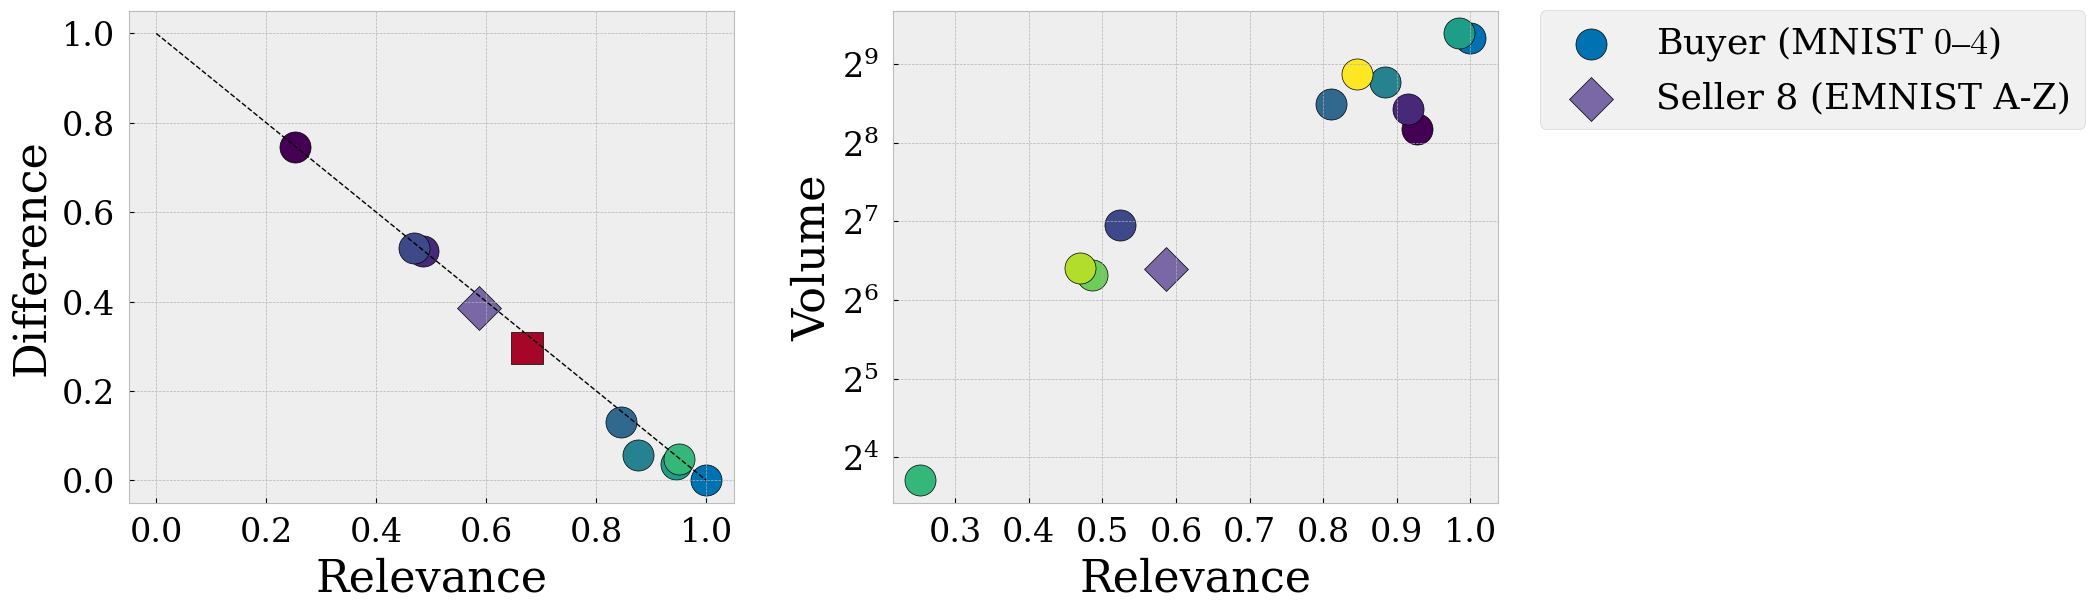

In [183]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 10)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs), c=viridis[6], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s')

# ax[0].set_xlim(0.5, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=viridis[0], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs)[0], seller2_vol, c=viridis[1], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs)[0], seller3_vol, c=viridis[2], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs)[0], seller4_vol, c=viridis[3], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs)[0], seller5_vol, c=viridis[4], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller6_vol, c=viridis[5], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[6], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[7], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[8], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[9], edgecolor='k', s=s, label=r'')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs)[0], seller13_vol, c=viridis[6], edgecolor='k', s=s, label=r'')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 8 (EMNIST A-Z)')
# ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 9 (FashionMNIST)')

# ax[1].set_xlim(0.5, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.04, 1.04))
# plt.savefig(figures / f'mnist-complex.pdf', bbox_inches='tight')
plt.show()

In [180]:
# np.linalg.cond(buyer_components @ seller1_cov.T)

In [181]:
buyer_eig_val.mean(), np.median(buyer_eig_val)

(3.5992274343790727, 0.0009336119610289459)

In [117]:
dup1_proj_cov = pca.transform(dup1_cov)
dup1_vol = get_volume(dup1_proj_cov, omega=omega)

dup2_proj_cov = pca.transform(dup2_cov)
dup2_vol = get_volume(dup2_proj_cov, omega=omega)

dup3_proj_cov = pca.transform(dup3_cov)
dup3_vol = get_volume(dup3_proj_cov, omega=omega)

dup4_proj_cov = pca.transform(dup4_cov)
dup4_vol = get_volume(dup4_proj_cov, omega=omega)

dup5_proj_cov = pca.transform(dup5_cov)
dup5_vol = get_volume(dup5_proj_cov, omega=omega)

mix1_proj_cov = pca.transform(mix1_cov)
mix1_vol = get_volume(mix1_proj_cov, omega=omega)

mix2_proj_cov = pca.transform(mix2_cov)
mix2_vol = get_volume(mix2_proj_cov, omega=omega)

mix3_proj_cov = pca.transform(mix3_cov)
mix3_vol = get_volume(mix3_proj_cov, omega=omega)

mix4_proj_cov = pca.transform(mix4_cov)
mix4_vol = get_volume(mix4_proj_cov, omega=omega)

mix5_proj_cov = pca.transform(mix5_cov)
mix5_vol = get_volume(mix5_proj_cov, omega=omega)

mix6_proj_cov = pca.transform(mix6_cov)
mix6_vol = get_volume(mix6_proj_cov, omega=omega)

mix7_proj_cov = pca.transform(mix7_cov)
mix7_vol = get_volume(mix7_proj_cov, omega=omega)

mix8_proj_cov = pca.transform(mix8_cov)
mix8_vol = get_volume(mix8_proj_cov, omega=omega)

mix9_proj_cov = pca.transform(mix9_cov)
mix9_vol = get_volume(mix9_proj_cov, omega=omega)


In [118]:
def div_rel_func(buyer_eig_vals, buyer_eig_vecs, seller_cov, threshold=1e-2, num_components=2):
    buyer_vals = buyer_eig_vals[:num_components]
    # buyer_vecs = np.abs(buyer_eig_vecs[:num_components])
    buyer_vecs = buyer_eig_vecs[:num_components]
    seller_vals = np.linalg.norm(seller_cov @ buyer_vecs.T, axis=0)

    # Diversity
    div_components = np.abs(buyer_vals - seller_vals) / np.maximum(buyer_vals, seller_vals)

    #  Relevance
    rel_components = np.minimum(buyer_vals, seller_vals) / np.maximum(buyer_vals, seller_vals)
    # print('div', div_components)
    # print('rel', rel_components)

    # filter buyer components by threshold 
    keep_mask = buyer_vals >= threshold

    div = np.prod(np.where(keep_mask, div_components, 1)) ** (1 / keep_mask.sum())
    rel = np.prod(np.where(keep_mask, rel_components, 1)) ** (1 / keep_mask.sum())
    return rel, div #, keep_mask.sum()

In [119]:
def div_rel_func2(buyer_eig_val, buyer_eig_vec, seller_covariance, num_components=None, threshold=1e-1):
    seller_eig_val = np.zeros([len(seller_covariance)])
    Diversity = 1
    Relevance = 1
    count_root = 0
    # div  = []
    # rel = []
    
    # buyer_eig_vec = np.abs(buyer_eig_vec)
    
    for i in range(len(seller_covariance)):
        if num_components is not None and i >= num_components:
            break
        elif buyer_eig_val[i] < threshold:
            continue
            
        count_root += 1
        vec_seller_covariance = np.matmul(seller_covariance, buyer_eig_vec[:, i])
        seller_eig_val[i] = np.abs(np.linalg.norm(vec_seller_covariance))
        # print((seller_eig_val[i], buyer_eig_val[i]))
        Diversity *= np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i])
        Relevance *= min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) 
        # div.append(np.abs(seller_eig_val[i] - buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]))
        # rel.append(min(seller_eig_val[i], buyer_eig_val[i]) / max(seller_eig_val[i], buyer_eig_val[i]) )

    # print(div)
    # print(rel)
    return (Relevance)**(1/count_root), (Diversity)**(1/count_root), count_root

In [120]:

# for num_components in (2, 5, 10, 15, 20):
#     # print(str(num_components).center(40, '-'))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller1_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller2_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller3_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller4_cov, threshold=threshold, num_components=num_components))
#     # print(div_rel_func2(buyer_eig_val, buyer_eig_vec, seller5_cov, threshold=threshold, num_components=num_components))
    
#     print(str(num_components).center(40, '-'))
#     print(div_rel_func(buyer_values, buyer_components, seller1_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller2_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller3_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller4_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller5_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller6_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller7_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller8_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller9_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, threshold=threshold, num_components=num_components))
#     print(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, threshold=threshold, num_components=num_components))
#     if use_features:
#         print(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, threshold=threshold, num_components=num_components))

In [121]:
threshold = 0.1
num_components = 2
# num_components = 3
# num_components = 4
# num_components = 10
kwargs = {'threshold': threshold, 'num_components': num_components}

In [122]:
import matplotlib

In [123]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
# rcParams['font.sans-serif'] = ['Tahoma']

In [124]:
figures = Path('figures')

/tmp/ipykernel_37078/2339956581.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/2339956581.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/2339956581.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
/tmp/ipykernel_37078/2339956581.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)


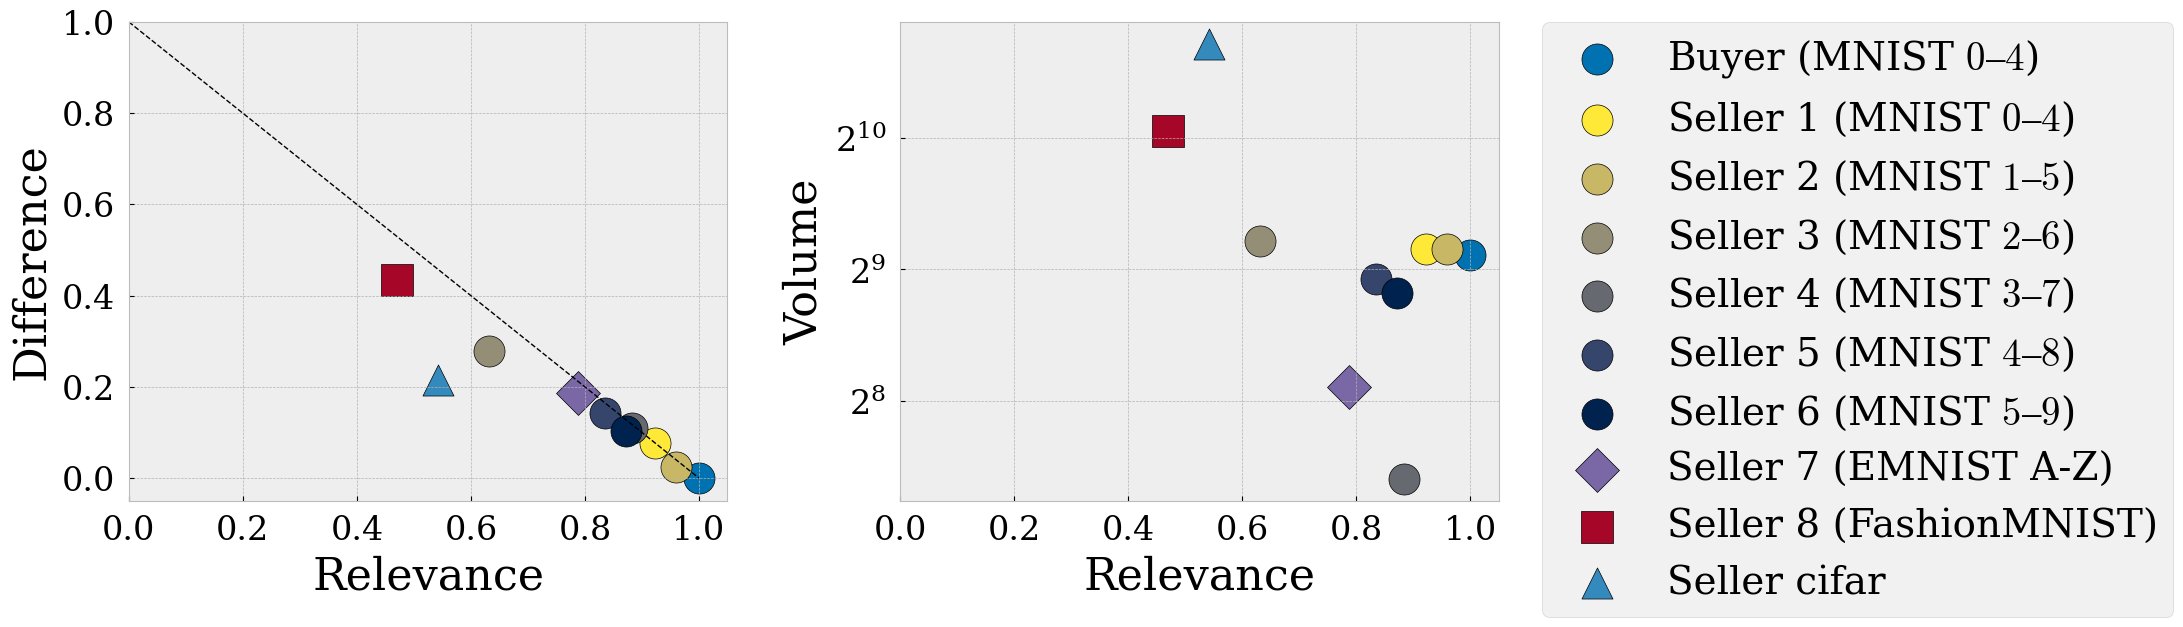

In [125]:
cividis = [np.array([matplotlib.colormaps['cividis'].colors[int(k)]]) for k in np.linspace(255, 0, 6)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 7), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=cividis[0], edgecolor='k', s=s, label=r'Seller mnist $0–4$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs), c=cividis[1], edgecolor='k', s=s, label=r'Seller mnist $1–5$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs), c=cividis[2], edgecolor='k', s=s, label=r'Seller mnist $2–6$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs), c=cividis[3], edgecolor='k', s=s, label=r'Seller mnist $3–7$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs), c=cividis[4], edgecolor='k', s=s, label=r'Seller mnist $4–8$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=cividis[5], edgecolor='k', s=s, label=r'Seller mnist $5–9$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D', label=r'Seller emnist')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s', label=r'Seller fashion')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(-0.05, 1)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=cividis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs)[0], seller1_vol, c=cividis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $1–5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs)[0], seller2_vol, c=cividis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $2–6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs)[0], seller3_vol, c=cividis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $3–7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs)[0], seller4_vol, c=cividis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $4–8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller5_vol, c=cividis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $5–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 7 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 8 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2) 
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(1.04, 1.04))
# plt.savefig(figures / f'mnist-overlap.pdf', bbox_inches='tight')
plt.show()

In [126]:
use_features

True

In [128]:
# s = 500
# plt.figure(figsize=(8, 8))

# plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=viridis[0], marker='P', edgecolor='k', s=s, label=r'Seller mnist $0$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], marker='X', edgecolor='k', s=s, label=r'Seller mnist $5$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s, label=r'Seller mnist $0, 5$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s, label=r'Seller mnist $0, 1, 5, 6$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s, label=r'Seller mnist $0–2, 5-7$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s, label=r'Seller mnist $0-3, 5-8$')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s, label=r'Seller mnist $0-9$')

# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), edgecolor='k', s=s, marker='s', label=r'Seller fashion')
# plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), edgecolor='k', s=s, marker='d', label=r'Seller emnist')
# if use_features:
#     plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

# plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
# plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
# plt.xlabel('Relevance', fontsize=32)
# plt.ylabel('Diversity', fontsize=32)
# plt.legend(prop={'size': 20}, bbox_to_anchor=(1.70, 1.00))
# plt.savefig(f'mnist-diversity-complex.png', bbox_inches='tight')
# plt.show()

In [83]:

# s = 500
# plt.figure(figsize=(8, 8))
# plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

# plt.scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller6_vol, c=viridis[0], marker='P', edgecolor='k', s=s, label=r'Seller mnist $0$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[0], marker='X', edgecolor='k', s=s, label=r'Seller mnist $5$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[1], edgecolor='k', s=s, label=r'Seller mnist $0, 5$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[2], edgecolor='k', s=s, label=r'Seller mnist $0, 1, 5, 6$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[3], edgecolor='k', s=s, label=r'Seller mnist $0–2, 5-7$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'Seller mnist $0-3, 5-8$')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'Seller mnist $0-9$')

# plt.scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, edgecolor='k', s=s, marker='s', label=r'Seller fashion')
# plt.scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, edgecolor='k', s=s, marker='d', label=r'Seller emnist')
# if use_features:
#     plt.scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

# plt.legend(prop={'size': 20}, bbox_to_anchor=(1.70, 1.00))
# plt.yscale('log',base=2) 
# plt.xlim(0, 1.05)
# # plt.ylim(0, 1.05)
# plt.xlabel('Relevance', fontsize=32)
# plt.ylabel('Volume', fontsize=32)
# plt.savefig(f'mnist-volume-compex.png', bbox_inches='tight')
# plt.show()


In [84]:
plasma = [matplotlib.colormaps['plasma'].colors[int(k)] for k in np.linspace(255, 0, 6)]

/tmp/ipykernel_37078/286841513.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (100%)')
/tmp/ipykernel_37078/286841513.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs), c=plasma[1], edgecolor='k', s=s,

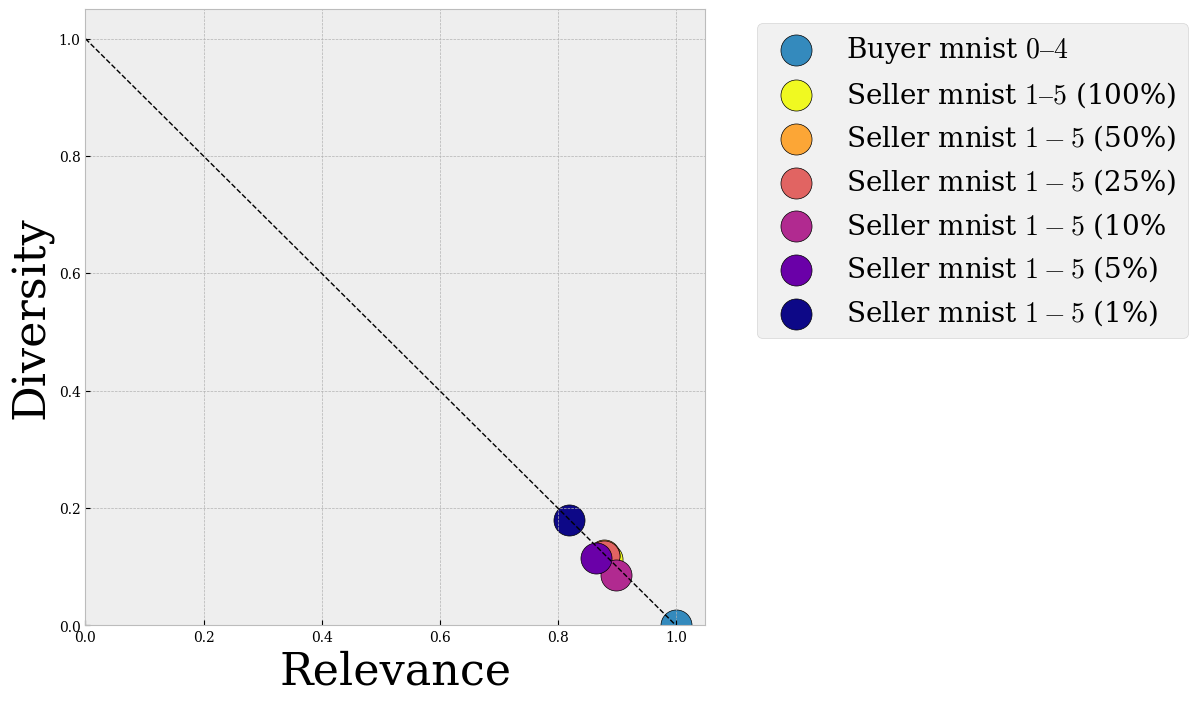

In [85]:
s = 500
plt.figure(figsize=(8, 8))

plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (100%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs), c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs), c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (25%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs), c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (10%')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs), c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (5%)')
plt.scatter(*div_rel_func(buyer_values, buyer_components, dup5_cov, **kwargs), c=plasma[5], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (1%)')


plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Diversity', fontsize=32)
plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
# plt.savefig(f'mnist-diversity-dup.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_37078/3635242539.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (100%)')
/tmp/ipykernel_37078/3635242539.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs)[0], dup1_vol, c=p

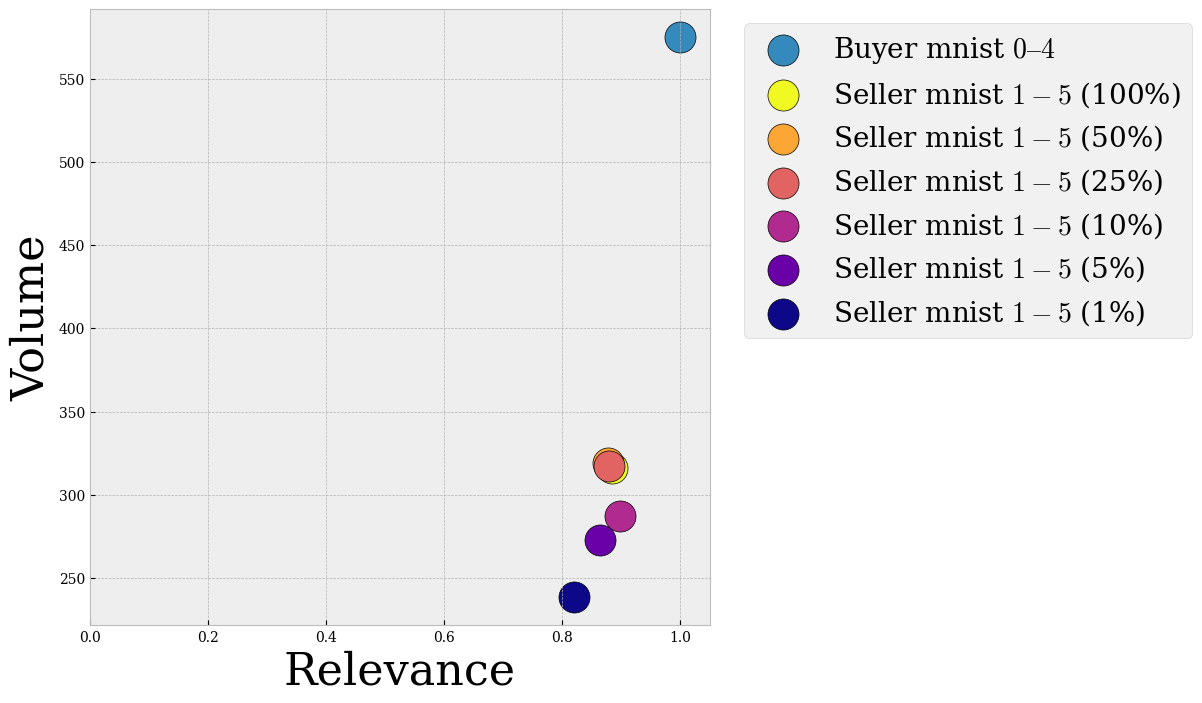

In [86]:
s = 500
plt.figure(figsize=(8, 8))
plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (100%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs)[0], dup1_vol, c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs)[0], dup2_vol, c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (25%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs)[0], dup3_vol, c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (10%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs)[0], dup4_vol, c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (5%)')
plt.scatter(div_rel_func(buyer_values, buyer_components, dup5_cov, **kwargs)[0], dup5_vol, c=plasma[5], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (1%)')

plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
# plt.yscale('log',base=2) 
plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Volume', fontsize=32)
# plt.savefig(f'mnist-volume-dup.png', bbox_inches='tight')
plt.show()


In [87]:
magma = [matplotlib.colormaps['magma'].colors[int(k)] for k in np.linspace(255, 0, 12)]

/tmp/ipykernel_37078/1678871615.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
/tmp/ipykernel_37078/1678871615.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=magma[1], edgecolor='k', s=s, labe

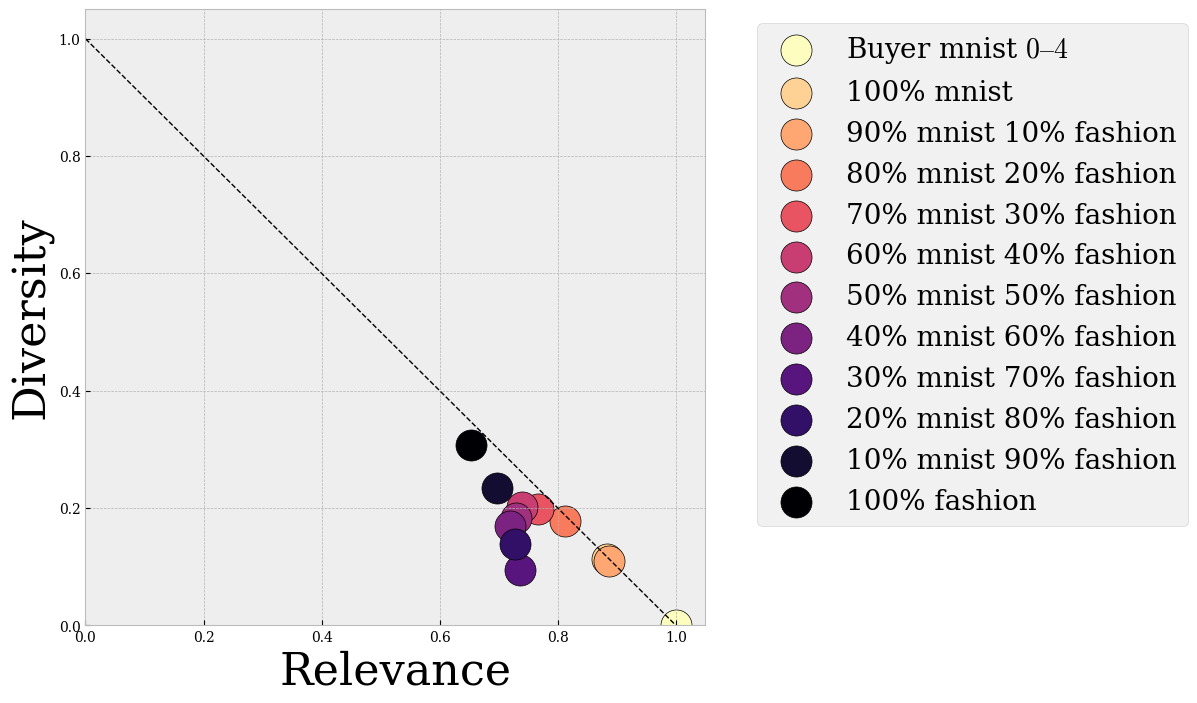

In [90]:

s = 500
plt.figure(figsize=(8, 8))

plt.scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=magma[1], edgecolor='k', s=s, label=r'100% mnist')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs), c=magma[2], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs), c=magma[3], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs), c=magma[4], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs), c=magma[5], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs), c=magma[6], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs), c=magma[7], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs), c=magma[8], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs), c=magma[9], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs), c=magma[10], edgecolor='k', s=s, label=r'10% mnist 90% fashion')
plt.scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c=magma[11], edgecolor='k', s=s, label=r'100% fashion')


plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Diversity', fontsize=32)
plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
# plt.savefig(f'mnist-diversity-mix.png', bbox_inches='tight')
plt.show()

/tmp/ipykernel_37078/2738567140.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,  c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
/tmp/ipykernel_37078/2738567140.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=magma

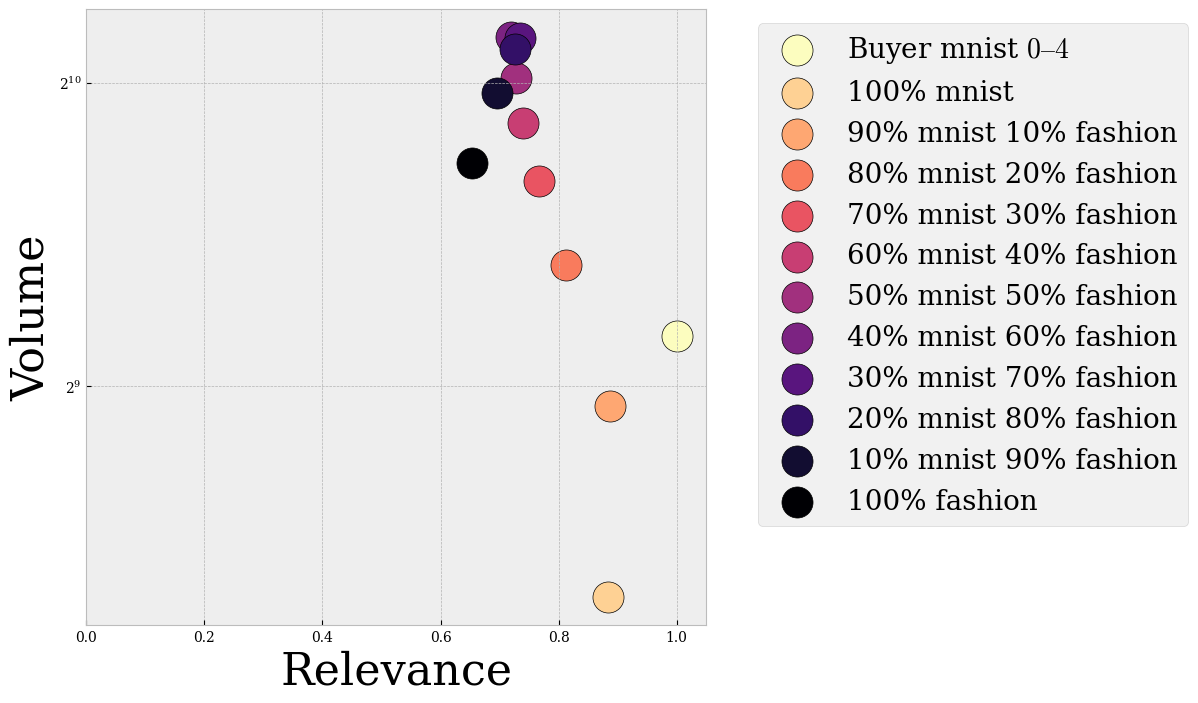

In [91]:
s = 500
plt.figure(figsize=(8, 8))
plt.scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,  c=magma[0], edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=magma[1], edgecolor='k', s=s, label=r'100% mnist')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs)[0], mix1_vol, c=magma[2], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs)[0], mix2_vol, c=magma[3], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs)[0], mix3_vol, c=magma[4], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs)[0], mix4_vol, c=magma[5], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs)[0], mix5_vol, c=magma[6], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs)[0], mix6_vol, c=magma[7], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs)[0], mix7_vol, c=magma[8], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs)[0], mix8_vol, c=magma[9], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
plt.scatter(div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs)[0], mix9_vol, c=magma[10], edgecolor='k', s=s, label=r'10% mnist 90% fashion')

plt.scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c=magma[11], edgecolor='k', s=s, label=r'100% fashion')

plt.legend(prop={'size': 20}, bbox_to_anchor=(1.80, 1.00))
plt.yscale('log',base=2) 
plt.xlim(0, 1.05)
# plt.ylim(0, 1.05)
plt.xlabel('Relevance', fontsize=32)
plt.ylabel('Volume', fontsize=32)
# plt.savefig(f'mnist-volume-mix.png', bbox_inches='tight')
plt.show()
